# Part 2) EDA, Recipe recommender

After scraping the required data to make up our recipe dataset, we will proceed next with EDA and building a recipe recommendation engine based on text inputs. We will also be using outputs from EDA to create our image dataset for custom training with a suitable deep learning computer vision model. This portion will not be covered in this notebook. It can be found in the google colab notebook found on the git repo. 

### Import libraries

In [126]:
import pandas as pd
import re
import numpy as np
from ast import literal_eval
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from IPython.display import Image, display
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import jaccard_score

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings('ignore')


In [2]:
prep_diff_df = pd.read_csv('prep_diff.csv')
print(prep_diff_df.shape)
prep_diff_df.head()


(778, 4)


,url,image,prep_time,difficulty
0,https://themeatmen.sg/jb-ah-meng-chao-da-bee-hoon/,https://themeatmen.sg/wp-content/uploads/2023/07/JB-Ah-Meng-Chao-Da-Bee-Hoon-scaled.jpg,['30 mins'],easy
1,https://themeatmen.sg/easy-thai-bbq-pork-collar/,https://themeatmen.sg/wp-content/uploads/2023/06/DSC09626-scaled.jpg,['20 minutes'],easy
2,https://themeatmen.sg/filipino-sinigang-na-baboy-hack/,https://themeatmen.sg/wp-content/uploads/2023/06/DSC09665-scaled.jpg,['1 hr 15 min'],easy
3,https://themeatmen.sg/mothers-day-special-manuka-honey-yogurt-parfait/,https://themeatmen.sg/wp-content/uploads/2023/05/DSC00752-1-scaled.jpg,['5 min'],easy
4,https://themeatmen.sg/mee-soto-2/,https://themeatmen.sg/wp-content/uploads/2023/04/DSC09768-scaled.jpg,['2 hour'],easy


In [3]:
meatmen_df = pd.read_csv('meatmen_scraped_raw.csv')
print(meatmen_df.shape)
meatmen_df.head(5)

(777, 5)


,url,image,ingredients,directions,recipe_name
0,https://themeatmen.sg/easy-thai-bbq-pork-collar/,https://themeatmen.sg/wp-content/uploads/2023/06/DSC09626-scaled.jpg,"['1kg Pork Collar', '2 tbsp Oyster sauce', '1 tbsp Fish sauce', '2 tbsp Light soy sauce', '1 tbsp Dark soy sauce', '4 tbsp Palm sugar', '1 tbsp White pepper powder', '1 Lemongrass', '3 Coriander roots', '4 Shallots', '3 stalks Coirander', '4-5 tbsp Fish sauce', '1 tbsp Tamarind paste', 'Juice from 1 lime', '1 tbsp Palm sugar', '1 tbsp Toasted rice powder (Khao Khua)', '1 tbsp Thai dried chilli flakes']","['1. Cut up pork collar into pork chops. Transfer to a large mixing bowl.', '2. Add oyster sauce, fish sauce, light soy sauce, dark soy sauce, palm sugar, white pepper powder, lemongrass, and coriander roots. Mix well and marinate meat.', '3. Refrigerate to marinade for at least 1 hour to overnight.', '4. To make toasted rice powder, add 1 cup of glutinous rice into a wide pan and toast over medium-low heat until lightly browned for about 8-10 minutes. Set aside to completely cool. Add toasted rice into a pestle and mortar to grind it into powder, or use a spice blender.', '5. To make Jaew แจ่ว (Thai Dried Chilli Dipping Sauce), add in sliced shallots, coriander roots, fish sauce, tamarind paste, lime juice, palm sugar, toasted rice powder. Thai dried chilli flakes into a mixing bowl and mix well. Remove coriander roots before serving.', '6. Wrap marinated pork collars in individual aluminium foils and lay on a baking tray.', '7. Cook in oven at 105°C for about 2 hours until meat is nice and tender.', '8. Remove foil from meats and lay on the baking tray, roast in the oven at 220°C for about 10 minutes on each side.', '9. Slice up pork collars, and serve with rice and dipping sauce.']",easy thai bbq pork collar
1,https://themeatmen.sg/filipino-sinigang-na-baboy-hack/,https://themeatmen.sg/wp-content/uploads/2023/06/DSC09665-scaled.jpg,"['2 tbsp Cooking oil', '1 kg Sio Bak', '4 cloves Garlic', '1 Onion', '2 Green Chillies', '1 Tomato', '1 litre Water', '1 litre Chicken Stock', '3 tbsp Fish Sauce', '1 tsp White pepper powder', '6 tbsp Tamarind paste', '1/2 Radish', '1/2 Eggplant', '200 g Taro', '200 g Lady Fingers', '100 g Kang Kong', '100 g Long beans']","['1. Cut up vegetables and aromatics and set aside.', '2. In a pot over medium heat, add 2 tbsp cooking oil. Cut up Sio bak and add into pot, pan fry until lightly charred on both sides.', '3. Push pork pieces aside and add in garlic, onion, green chilies, and tomatoes.', '4. Add water and chicken stock, season with fish sauce, white pepper powder and tamarind paste. Mix well.', '5. Cover and simmer on low heat for about 30 minutes.', '6. Add in Taro, Radish, Eggplant, Tomatoes, Lady Fingers, Long beans and Kang kong. Cover and simmer for about 15 minutes.', '7. Serve and enjoy with rice.']",filipino sinigang na baboy hack
2,https://themeatmen.sg/mothers-day-special-manuka-honey-yogurt-parfait/,https://themeatmen.sg/wp-content/uploads/2023/05/DSC00752-1-scaled.jpg,"['4 tbsp Eu Yan Sang Manuka Honey', '50 g Eu Yan Sang Organic Barbary Wolfberry Fruit', '3 packs Eu Yan Sang Herbal Cookies Chocolate Chips with Goji', '2 tbsp Eu Yan Sang Organic Chia Seeds', '2 cups Greek Yoghurt', '150 g Strawberries', '150 g Blueberries']","['1. Add in Eu Yan Sang Herbal Cookies Chocolate Chips With Goji into a zip lock bag, crush, and set aside.', '2. Cut up strawberries into cubes and prepare the garnish.', '3. In 2 glasses layer parfait, starting with Greek yogurt, crushed cookies, fruits, Wolfberries, chia seeds, Eu Yan Sang Manuka Honey, and repeat for another layer.', '4. Garnish with strawberries and serve.']",mothers day special manuka honey yogurt parfait
3,https://themeatmen.sg/mee-soto-2/,https://themeatmen.sg/wp-content/uploads/2023/04/DSC09768-scaled.jpg,"['200 g Red onions', '8 cloves Garlic', '40 g Ginger', '2 Lemongrass (white part)', '8 Candlenut', '1 tsp Turmeric powder', '1 tbsp Coriander powder', '1 tsp Cumin po

In [4]:
# checking recipe names 
meatmen_df.recipe_name

0                                                                      easy thai bbq pork collar
1                                                                filipino sinigang na baboy hack
2                                                mothers day special manuka honey yogurt parfait
3                                                                                     mee soto 2
4                                                                               yakiniku donburi
5                                       indonesia begedil hack making begedil using french fries
6                                                                       zi char style mee goreng
7                                                                       4 ways to use monk fruit
8                                                                             black chicken soup
9                                                                  jia xiang old school mee siam
10                            

In [55]:
# upon further inspection, recipe names that seem to be gibberish are actually due to an encoding of mandarin characters.
# we will not clean these text and will encode back into mandarin in html deployment. 
meatmen_df['recipe_name'].iloc[199:207]


218    cuttlefish ball kimchi stew
219           pork trotter beehoon
220            fish head steamboat
221                chicken karaage
222        japanese soft milk buns
224                 local mee siam
225      gyudon japanese beef bowl
226           tok wan beef rendang
Name: recipe_name, dtype: object

In [6]:
meatmen_df = pd.merge(prep_diff_df, meatmen_df, on=['url','image'])
print(meatmen_df.shape)
meatmen_df.head()

(777, 7)


,url,image,prep_time,difficulty,ingredients,directions,recipe_name
0,https://themeatmen.sg/easy-thai-bbq-pork-collar/,https://themeatmen.sg/wp-content/uploads/2023/06/DSC09626-scaled.jpg,['20 minutes'],easy,"['1kg Pork Collar', '2 tbsp Oyster sauce', '1 tbsp Fish sauce', '2 tbsp Light soy sauce', '1 tbsp Dark soy sauce', '4 tbsp Palm sugar', '1 tbsp White pepper powder', '1 Lemongrass', '3 Coriander roots', '4 Shallots', '3 stalks Coirander', '4-5 tbsp Fish sauce', '1 tbsp Tamarind paste', 'Juice from 1 lime', '1 tbsp Palm sugar', '1 tbsp Toasted rice powder (Khao Khua)', '1 tbsp Thai dried chilli flakes']","['1. Cut up pork collar into pork chops. Transfer to a large mixing bowl.', '2. Add oyster sauce, fish sauce, light soy sauce, dark soy sauce, palm sugar, white pepper powder, lemongrass, and coriander roots. Mix well and marinate meat.', '3. Refrigerate to marinade for at least 1 hour to overnight.', '4. To make toasted rice powder, add 1 cup of glutinous rice into a wide pan and toast over medium-low heat until lightly browned for about 8-10 minutes. Set aside to completely cool. Add toasted rice into a pestle and mortar to grind it into powder, or use a spice blender.', '5. To make Jaew แจ่ว (Thai Dried Chilli Dipping Sauce), add in sliced shallots, coriander roots, fish sauce, tamarind paste, lime juice, palm sugar, toasted rice powder. Thai dried chilli flakes into a mixing bowl and mix well. Remove coriander roots before serving.', '6. Wrap marinated pork collars in individual aluminium foils and lay on a baking tray.', '7. Cook in oven at 105°C for about 2 hours until meat is nice and tender.', '8. Remove foil from meats and lay on the baking tray, roast in the oven at 220°C for about 10 minutes on each side.', '9. Slice up pork collars, and serve with rice and dipping sauce.']",easy thai bbq pork collar
1,https://themeatmen.sg/filipino-sinigang-na-baboy-hack/,https://themeatmen.sg/wp-content/uploads/2023/06/DSC09665-scaled.jpg,['1 hr 15 min'],easy,"['2 tbsp Cooking oil', '1 kg Sio Bak', '4 cloves Garlic', '1 Onion', '2 Green Chillies', '1 Tomato', '1 litre Water', '1 litre Chicken Stock', '3 tbsp Fish Sauce', '1 tsp White pepper powder', '6 tbsp Tamarind paste', '1/2 Radish', '1/2 Eggplant', '200 g Taro', '200 g Lady Fingers', '100 g Kang Kong', '100 g Long beans']","['1. Cut up vegetables and aromatics and set aside.', '2. In a pot over medium heat, add 2 tbsp cooking oil. Cut up Sio bak and add into pot, pan fry until lightly charred on both sides.', '3. Push pork pieces aside and add in garlic, onion, green chilies, and tomatoes.', '4. Add water and chicken stock, season with fish sauce, white pepper powder and tamarind paste. Mix well.', '5. Cover and simmer on low heat for about 30 minutes.', '6. Add in Taro, Radish, Eggplant, Tomatoes, Lady Fingers, Long beans and Kang kong. Cover and simmer for about 15 minutes.', '7. Serve and enjoy with rice.']",filipino sinigang na baboy hack
2,https://themeatmen.sg/mothers-day-special-manuka-honey-yogurt-parfait/,https://themeatmen.sg/wp-content/uploads/2023/05/DSC00752-1-scaled.jpg,['5 min'],easy,"['4 tbsp Eu Yan Sang Manuka Honey', '50 g Eu Yan Sang Organic Barbary Wolfberry Fruit', '3 packs Eu Yan Sang Herbal Cookies Chocolate Chips with Goji', '2 tbsp Eu Yan Sang Organic Chia Seeds', '2 cups Greek Yoghurt', '150 g Strawberries', '150 g Blueberries']","['1. Add in Eu Yan Sang Herbal Cookies Chocolate Chips With Goji into a zip lock bag, crush, and set aside.', '2. Cut up strawberries into cubes and prepare the garnish.', '3. In 2 glasses layer parfait, starting with Greek yogurt, crushed cookies, fruits, Wolfberries, chia seeds, Eu Yan Sang Manuka Honey, and repeat for another layer.', '4. Garnish with strawberries and serve.']",mothers day special manuka honey yogurt parfait
3,https://themeatmen.sg/mee-soto-2/,https://themeatmen.sg/wp-content/uploads/2023/04/DSC09768-scaled.jpg,['2 hour'],easy,"['200 g Red onions', '8 cloves Garlic', '40 g Ginger', '2 Lemongrass (whi

In [7]:
# check for missing values 
meatmen_df.isnull().sum()

url             0
image           0
prep_time      51
difficulty      0
ingredients     0
directions      0
recipe_name     0
dtype: int64

There are 103 rows containing empty lists in `ingredients`. We will remove these.

In [8]:
meatmen_df.difficulty.unique()
difficulty_mapping = {'super easy': 1, 'easy': 2, 'medium': 3, 'hard': 4}
meatmen_df['difficulty_scale'] = meatmen_df['difficulty'].map(difficulty_mapping)


In [80]:
meatmen_df.head()

,url,image,prep_time,difficulty,ingredients,directions,recipe_name,difficulty_scale,prep_time_minutes
0,https://themeatmen.sg/easy-thai-bbq-pork-collar/,https://themeatmen.sg/wp-content/uploads/2023/06/DSC09626-scaled.jpg,['20 minutes'],easy,"['1kg Pork Collar', '2 tbsp Oyster sauce', '1 tbsp Fish sauce', '2 tbsp Light soy sauce', '1 tbsp Dark soy sauce', '4 tbsp Palm sugar', '1 tbsp White pepper powder', '1 Lemongrass', '3 Coriander roots', '4 Shallots', '3 stalks Coirander', '4-5 tbsp Fish sauce', '1 tbsp Tamarind paste', 'Juice from 1 lime', '1 tbsp Palm sugar', '1 tbsp Toasted rice powder (Khao Khua)', '1 tbsp Thai dried chilli flakes']","['1. Cut up pork collar into pork chops. Transfer to a large mixing bowl.', '2. Add oyster sauce, fish sauce, light soy sauce, dark soy sauce, palm sugar, white pepper powder, lemongrass, and coriander roots. Mix well and marinate meat.', '3. Refrigerate to marinade for at least 1 hour to overnight.', '4. To make toasted rice powder, add 1 cup of glutinous rice into a wide pan and toast over medium-low heat until lightly browned for about 8-10 minutes. Set aside to completely cool. Add toasted rice into a pestle and mortar to grind it into powder, or use a spice blender.', '5. To make Jaew แจ่ว (Thai Dried Chilli Dipping Sauce), add in sliced shallots, coriander roots, fish sauce, tamarind paste, lime juice, palm sugar, toasted rice powder. Thai dried chilli flakes into a mixing bowl and mix well. Remove coriander roots before serving.', '6. Wrap marinated pork collars in individual aluminium foils and lay on a baking tray.', '7. Cook in oven at 105°C for about 2 hours until meat is nice and tender.', '8. Remove foil from meats and lay on the baking tray, roast in the oven at 220°C for about 10 minutes on each side.', '9. Slice up pork collars, and serve with rice and dipping sauce.']",easy thai bbq pork collar,2,1220
1,https://themeatmen.sg/filipino-sinigang-na-baboy-hack/,https://themeatmen.sg/wp-content/uploads/2023/06/DSC09665-scaled.jpg,['1 hr 15 min'],easy,"['2 tbsp Cooking oil', '1 kg Sio Bak', '4 cloves Garlic', '1 Onion', '2 Green Chillies', '1 Tomato', '1 litre Water', '1 litre Chicken Stock', '3 tbsp Fish Sauce', '1 tsp White pepper powder', '6 tbsp Tamarind paste', '1/2 Radish', '1/2 Eggplant', '200 g Taro', '200 g Lady Fingers', '100 g Kang Kong', '100 g Long beans']","['1. Cut up vegetables and aromatics and set aside.', '2. In a pot over medium heat, add 2 tbsp cooking oil. Cut up Sio bak and add into pot, pan fry until lightly charred on both sides.', '3. Push pork pieces aside and add in garlic, onion, green chilies, and tomatoes.', '4. Add water and chicken stock, season with fish sauce, white pepper powder and tamarind paste. Mix well.', '5. Cover and simmer on low heat for about 30 minutes.', '6. Add in Taro, Radish, Eggplant, Tomatoes, Lady Fingers, Long beans and Kang kong. Cover and simmer for about 15 minutes.', '7. Serve and enjoy with rice.']",filipino sinigang na baboy hack,2,61
2,https://themeatmen.sg/mothers-day-special-manuka-honey-yogurt-parfait/,https://themeatmen.sg/wp-content/uploads/2023/05/DSC00752-1-scaled.jpg,['5 min'],easy,"['4 tbsp Eu Yan Sang Manuka Honey', '50 g Eu Yan Sang Organic Barbary Wolfberry Fruit', '3 packs Eu Yan Sang Herbal Cookies Chocolate Chips with Goji', '2 tbsp Eu Yan Sang Organic Chia Seeds', '2 cups Greek Yoghurt', '150 g Strawberries', '150 g Blueberries']","['1. Add in Eu Yan Sang Herbal Cookies Chocolate Chips With Goji into a zip lock bag, crush, and set aside.', '2. Cut up strawberries into cubes and prepare the garnish.', '3. In 2 glasses layer parfait, starting with Greek yogurt, crushed cookies, fruits, Wolfberries, chia seeds, Eu Yan Sang Manuka Honey, and repeat for another layer.', '4. Garnish with strawberries and serve.']",mothers day special manuka honey yogurt parfait,2,305
3,https://themeatmen.sg/mee-soto-2/,https://themeatmen.sg/wp-content/uploads/2023/04/DSC09768-scaled.jpg,['2 hour'],easy,"['200 g Red onions',

In [9]:
meatmen_df[meatmen_df['prep_time'].isnull()]


,url,image,prep_time,difficulty,ingredients,directions,recipe_name,difficulty_scale
11,https://themeatmen.sg/6-ingredients-series-3-course-valentines-day-dinner/,https://themeatmen.sg/wp-content/uploads/2023/02/DSC08343-1-scaled.jpg,NaN,super easy,[],[],6 ingredients series 3 course valentines day dinner,1
16,https://themeatmen.sg/carrot-cake-from-scratch/,https://themeatmen.sg/wp-content/uploads/2023/02/DSC04916-scaled.jpg,NaN,super easy,"['400 g Shredded White Radish', '250 g Rice flour', '50 g Tapioca flour', '600 ml Water', '1 tbsp Cooking oil', '1/2 tbsp Salt', '350 g Steamed Carrot Cake (Homemade or packet)', '4 tbsp Pork lard', '3 tbsp Minced garlic', '2 tbsp Chye Poh (wash to get rid of excess salt)', '25 g Beansprouts', '3 eggs', '1 tsp Fish sauce', '2 tbsp Kecap manis (for black version)', 'Chopped spring onions']","['1. Using a mandoline or a grater, slice radish into thin strips.', '2. Add rice flour, tapioca flour and salt into water and mix until smooth.', '3. In a wok pan over medium low heat, add cooking oil, and shredded radish.', '4. Stir fry for about 5 minutes, covering in between, add some water if the pan becomes too dry.', '5. Turn heat down to low and add in flour mixture. Mix until mixture forms a sticky paste.', '6. Transfer mixture into an oiled baking tin.', '7. Steam for 1 hour 30 minutes. Remove and set aside to room temperature, refrigerate overnight if possible.', '8. Cut carrot cake into cubes and measure out 350g.', '9. In a pan over medium heat, add in pork lard, minced garlic, Chye poh, and stir fry until fragrant.', '10. Add in carrot cake and stir fry, not moving them around too much to get a nice char.', '11. Add in fish sauce and mix well.', '12. Add in beaten eggs and leave for 1-2 minutes until nice and charred. Cut into four pieces and flip them individually.', '13. Add in bean sprouts and stir fry.', '14. Plate half of carrot cake as “White carrot cake”', '15. Chop the other half into smaller pieces and add in Kecap manis. Stir fry evenly and plate as “Black carrot cake”.', '16. Garnish with spring onions.']",carrot cake from scratch,1
18,https://themeatmen.sg/itek-tim/,https://themeatmen.sg/wp-content/uploads/2023/01/DSC00730-scaled.jpg,NaN,super easy,"['2 liters Water', '6 Duck legs', '500 g Pork ribs', '500 g Pickled Mustard Vegetables', '6 Chinese pickled plums', '4 pieces Assam skin', '2 Tomatoes', '50 g Ginger', '4 tbsp Shaoxing wine', '1 tsp Salt to taste', 'Pickled chillies']","['1. In a pot of boiling water, add in pork ribs and blanch for about 10 minutes.', '2. In a new pot of boiling water, add duck legs, blanch for about 10 minutes.', '3. In a fresh pot, add duck legs and pork ribs over medium heat. Add cut pickled mustard vegetables, sliced ginger, assam skin, pickled plums, water and salt.', '4. Cover and simmer for about 1 hour-1.5 hours', '5. Add tomatoes and Shaoxing wine. Cook for about 15 minutes.', '6. Serve hot.']",itek tim,1
28,https://themeatmen.sg/shrimp-mapo-tofu/,https://themeatmen.sg/wp-content/uploads/2023/01/DSC00404-scaled.jpg,NaN,super easy,"['450 g Fortune Silken Tofu', '200 g Shrimp (chopped)', '1 inch knob Ginger (minced)', ""1 Bird's Eye Chilli (chopped)"", '1/2 tsp Sichuan Peppercorns', '2 tbsp Cooking oil', '1 tbsp Chilli Bean Sauce (Doubanjiang)', '1/2 tbsp Fermented black beans', '1 tbsp Sichuan Red Pepper Flakes', '1cup Water', '1/2 tsp (24 twists on fine) McCormick Himalayan Pink Salt', '1/2 tsp (24 twists on fine) McCormick Black Pepper', '1/2 tsp Dark soy sauce', '4 tbsp Cornstarch solution (2:2 cornstarch to water)', 'Spring Onion']","['1. Roughly chop shrimp into small pieces. Cut tofu into cubes.', '2. In a wokpan over medium heat, add 2 tbsp cooking oil. Add ginger, chilli, szechuan peppercorns and stir fry until fragrant. Add Shrimp, season with McCormick Himalayan Pink Salt/McCormick Iodized Sea Salt, McCormick Black Pepper and stir fry.', '3. Add chilli bean sauce, fermented black beans, sichuan red pepper flakes and mix well.', '4. 

In [10]:
# check for empty lists in ingredients and directions
empty_ingredients = meatmen_df[meatmen_df['ingredients'] == '[]']
print(empty_ingredients.shape)
print(empty_ingredients)

empty_directions = meatmen_df[meatmen_df['directions'] == '[]']
print(empty_directions.shape)
print(empty_directions)

(103, 8)
                                                                                                           url  \
7                                                              https://themeatmen.sg/4-ways-to-use-monk-fruit/   
11                                  https://themeatmen.sg/6-ingredients-series-3-course-valentines-day-dinner/   
87                                                          https://themeatmen.sg/coffee-sauce-by-kek-seafood/   
89                                                                     https://themeatmen.sg/chilli-crab-tofu/   
95                                                     https://themeatmen.sg/lamb-ribs-with-furikake-by-hamzi/   
108                                                                          https://themeatmen.sg/kueh-talam/   
147                                           https://themeatmen.sg/air-fryer-chicken-thighs-marinated-3-ways/   
149                                               https://themeatmen.sg/seafood

In [11]:
meatmen_df = meatmen_df[meatmen_df['ingredients'] != '[]'] #filtering out recipes that contain empty lists 
meatmen_df = meatmen_df[meatmen_df['directions'] != '[]'] #filtering out recipes that contain empty directions 
print(meatmen_df.shape)

meatmen_df.to_csv('meatmen_scraped_filtered.csv', index=False)

(668, 8)


In [12]:
ingredients_df = meatmen_df[['recipe_name','ingredients']]

ingredients_df['n_directions'] = meatmen_df['directions'].apply(literal_eval).apply(len)

ingredients_df.head()

,recipe_name,ingredients,n_directions
0,easy thai bbq pork collar,"['1kg Pork Collar', '2 tbsp Oyster sauce', '1 tbsp Fish sauce', '2 tbsp Light soy sauce', '1 tbsp Dark soy sauce', '4 tbsp Palm sugar', '1 tbsp White pepper powder', '1 Lemongrass', '3 Coriander roots', '4 Shallots', '3 stalks Coirander', '4-5 tbsp Fish sauce', '1 tbsp Tamarind paste', 'Juice from 1 lime', '1 tbsp Palm sugar', '1 tbsp Toasted rice powder (Khao Khua)', '1 tbsp Thai dried chilli flakes']",9
1,filipino sinigang na baboy hack,"['2 tbsp Cooking oil', '1 kg Sio Bak', '4 cloves Garlic', '1 Onion', '2 Green Chillies', '1 Tomato', '1 litre Water', '1 litre Chicken Stock', '3 tbsp Fish Sauce', '1 tsp White pepper powder', '6 tbsp Tamarind paste', '1/2 Radish', '1/2 Eggplant', '200 g Taro', '200 g Lady Fingers', '100 g Kang Kong', '100 g Long beans']",7
2,mothers day special manuka honey yogurt parfait,"['4 tbsp Eu Yan Sang Manuka Honey', '50 g Eu Yan Sang Organic Barbary Wolfberry Fruit', '3 packs Eu Yan Sang Herbal Cookies Chocolate Chips with Goji', '2 tbsp Eu Yan Sang Organic Chia Seeds', '2 cups Greek Yoghurt', '150 g Strawberries', '150 g Blueberries']",4
3,mee soto 2,"['200 g Red onions', '8 cloves Garlic', '40 g Ginger', '2 Lemongrass (white part)', '8 Candlenut', '1 tsp Turmeric powder', '1 tbsp Coriander powder', '1 tsp Cumin powder', '3 tbsp Water', '4 tbsp Cooking oil', '20 Cardamom pods', '5 Star anise', '10 Cloves', '1 Cinnamon stick', '1 whole Chicken', '2 litres Water', '2 tbsp Salt', '1 tbsp Sugar', '500 g Yellow noodles', '200 g Beansprouts', '4 boiled Eggs', 'Fried Shallots', 'Coriander']",9
4,yakiniku donburi,"['250 g Iberico Presa', '250 g Iberico Pluma', '250g Iberico Secreto', '4 tbsp Light soy sauce', '3 tbsp Honey', '3 tbsp Sake', '3 tbsp Mirin', '2 tbsp Vinegar', '2 tbsp Sesame oil', '1 tbsp Grated garlic', '1 Apple', '2 tbsp Cooking oil', 'Salt and pepper to taste', '4 tbsp Furikake', '4 cups Japanese rice', 'Poached egg', 'Toasted Sesame seeds']",8


In [13]:
# Convert the strings into lists - comment this after first run
ingredients_df['ingredients'] = ingredients_df['ingredients'].apply(literal_eval) 

def extract_ingredients(ingredients_list):
    # The regex pattern to split at numbers, fractions, and measurement units
    pattern = re.compile(r'\d+-\d+|\d+|\d+\/\d+|\bcup\b|\bkg\b|\bcube\b|\bcubes\b|\bof\b|\bknob\b|\btbs\b|\bfrom\b|\bwith\b|\btbsp\b|\btsp\b|\bml\b|\bg\b|\boz\b|\bteaspoon\b|\btablespoon\b|\blitres\b|\blitre\b|\bcups\b|\bpack\b|\bpacks\b|\bpinch\b|\bcan\b|\bslice\b|\bstalk\b|\bpiece\b|½|¼|⅛|¾|⅓', re.IGNORECASE)

    # Split the strings at the pattern, and remove leading/trailing whitespace from each split string
    ex_ingredients = []
    for ingredient in ingredients_list:
        ingredient = re.sub(pattern, '', ingredient).strip()
        ingredient = ingredient.lower()
        ingredient = re.sub(pattern, '', ingredient).strip()
        ex_ingredients.append(ingredient)
    
    return ex_ingredients

# Apply the function to the 'ingredients' column
ingredients_df['ingredients_ex'] = ingredients_df['ingredients'].apply(extract_ingredients)



ingredients_df.head()






,recipe_name,ingredients,n_directions,ingredients_ex
0,easy thai bbq pork collar,"[1kg Pork Collar, 2 tbsp Oyster sauce, 1 tbsp Fish sauce, 2 tbsp Light soy sauce, 1 tbsp Dark soy sauce, 4 tbsp Palm sugar, 1 tbsp White pepper powder, 1 Lemongrass, 3 Coriander roots, 4 Shallots, 3 stalks Coirander, 4-5 tbsp Fish sauce, 1 tbsp Tamarind paste, Juice from 1 lime, 1 tbsp Palm sugar, 1 tbsp Toasted rice powder (Khao Khua), 1 tbsp Thai dried chilli flakes]",9,"[pork collar, oyster sauce, fish sauce, light soy sauce, dark soy sauce, palm sugar, white pepper powder, lemongrass, coriander roots, shallots, stalks coirander, fish sauce, tamarind paste, juice lime, palm sugar, toasted rice powder (khao khua), thai dried chilli flakes]"
1,filipino sinigang na baboy hack,"[2 tbsp Cooking oil, 1 kg Sio Bak, 4 cloves Garlic, 1 Onion, 2 Green Chillies, 1 Tomato, 1 litre Water, 1 litre Chicken Stock, 3 tbsp Fish Sauce, 1 tsp White pepper powder, 6 tbsp Tamarind paste, 1/2 Radish, 1/2 Eggplant, 200 g Taro, 200 g Lady Fingers, 100 g Kang Kong, 100 g Long beans]",7,"[cooking oil, sio bak, cloves garlic, onion, green chillies, tomato, water, chicken stock, fish sauce, white pepper powder, tamarind paste, / radish, / eggplant, taro, lady fingers, kang kong, long beans]"
2,mothers day special manuka honey yogurt parfait,"[4 tbsp Eu Yan Sang Manuka Honey, 50 g Eu Yan Sang Organic Barbary Wolfberry Fruit, 3 packs Eu Yan Sang Herbal Cookies Chocolate Chips with Goji, 2 tbsp Eu Yan Sang Organic Chia Seeds, 2 cups Greek Yoghurt, 150 g Strawberries, 150 g Blueberries]",4,"[eu yan sang manuka honey, eu yan sang organic barbary wolfberry fruit, eu yan sang herbal cookies chocolate chips goji, eu yan sang organic chia seeds, greek yoghurt, strawberries, blueberries]"
3,mee soto 2,"[200 g Red onions, 8 cloves Garlic, 40 g Ginger, 2 Lemongrass (white part), 8 Candlenut, 1 tsp Turmeric powder, 1 tbsp Coriander powder, 1 tsp Cumin powder, 3 tbsp Water, 4 tbsp Cooking oil, 20 Cardamom pods, 5 Star anise, 10 Cloves, 1 Cinnamon stick, 1 whole Chicken, 2 litres Water, 2 tbsp Salt, 1 tbsp Sugar, 500 g Yellow noodles, 200 g Beansprouts, 4 boiled Eggs, Fried Shallots, Coriander]",9,"[red onions, cloves garlic, ginger, lemongrass (white part), candlenut, turmeric powder, coriander powder, cumin powder, water, cooking oil, cardamom pods, star anise, cloves, cinnamon stick, whole chicken, water, salt, sugar, yellow noodles, beansprouts, boiled eggs, fried shallots, coriander]"
4,yakiniku donburi,"[250 g Iberico Presa, 250 g Iberico Pluma, 250g Iberico Secreto, 4 tbsp Light soy sauce, 3 tbsp Honey, 3 tbsp Sake, 3 tbsp Mirin, 2 tbsp Vinegar, 2 tbsp Sesame oil, 1 tbsp Grated garlic, 1 Apple, 2 tbsp Cooking oil, Salt and pepper to taste, 4 tbsp Furikake, 4 cups Japanese rice, Poached egg, Toasted Sesame seeds]",8,"[iberico presa, iberico pluma, iberico secreto, light soy sauce, honey, sake, mirin, vinegar, sesame oil, grated garlic, apple, cooking oil, salt and pepper to taste, furikake, japanese rice, poached egg, toasted sesame seeds]"


In [14]:
ingred_ex_df = ingredients_df[['recipe_name','ingredients_ex', 'n_directions']]
ingred_ex_df.to_csv('ex_ingred_name.csv', index=False)
ingred_ex_df.head()

,recipe_name,ingredients_ex,n_directions
0,easy thai bbq pork collar,"[pork collar, oyster sauce, fish sauce, light soy sauce, dark soy sauce, palm sugar, white pepper powder, lemongrass, coriander roots, shallots, stalks coirander, fish sauce, tamarind paste, juice lime, palm sugar, toasted rice powder (khao khua), thai dried chilli flakes]",9
1,filipino sinigang na baboy hack,"[cooking oil, sio bak, cloves garlic, onion, green chillies, tomato, water, chicken stock, fish sauce, white pepper powder, tamarind paste, / radish, / eggplant, taro, lady fingers, kang kong, long beans]",7
2,mothers day special manuka honey yogurt parfait,"[eu yan sang manuka honey, eu yan sang organic barbary wolfberry fruit, eu yan sang herbal cookies chocolate chips goji, eu yan sang organic chia seeds, greek yoghurt, strawberries, blueberries]",4
3,mee soto 2,"[red onions, cloves garlic, ginger, lemongrass (white part), candlenut, turmeric powder, coriander powder, cumin powder, water, cooking oil, cardamom pods, star anise, cloves, cinnamon stick, whole chicken, water, salt, sugar, yellow noodles, beansprouts, boiled eggs, fried shallots, coriander]",9
4,yakiniku donburi,"[iberico presa, iberico pluma, iberico secreto, light soy sauce, honey, sake, mirin, vinegar, sesame oil, grated garlic, apple, cooking oil, salt and pepper to taste, furikake, japanese rice, poached egg, toasted sesame seeds]",8


In [15]:
ingred_ex_df['n_all_ingredients'] = ingred_ex_df['ingredients_ex'].apply(len)

ingred_ex_df.head()


,recipe_name,ingredients_ex,n_directions,n_all_ingredients
0,easy thai bbq pork collar,"[pork collar, oyster sauce, fish sauce, light soy sauce, dark soy sauce, palm sugar, white pepper powder, lemongrass, coriander roots, shallots, stalks coirander, fish sauce, tamarind paste, juice lime, palm sugar, toasted rice powder (khao khua), thai dried chilli flakes]",9,17
1,filipino sinigang na baboy hack,"[cooking oil, sio bak, cloves garlic, onion, green chillies, tomato, water, chicken stock, fish sauce, white pepper powder, tamarind paste, / radish, / eggplant, taro, lady fingers, kang kong, long beans]",7,17
2,mothers day special manuka honey yogurt parfait,"[eu yan sang manuka honey, eu yan sang organic barbary wolfberry fruit, eu yan sang herbal cookies chocolate chips goji, eu yan sang organic chia seeds, greek yoghurt, strawberries, blueberries]",4,7
3,mee soto 2,"[red onions, cloves garlic, ginger, lemongrass (white part), candlenut, turmeric powder, coriander powder, cumin powder, water, cooking oil, cardamom pods, star anise, cloves, cinnamon stick, whole chicken, water, salt, sugar, yellow noodles, beansprouts, boiled eggs, fried shallots, coriander]",9,23
4,yakiniku donburi,"[iberico presa, iberico pluma, iberico secreto, light soy sauce, honey, sake, mirin, vinegar, sesame oil, grated garlic, apple, cooking oil, salt and pepper to taste, furikake, japanese rice, poached egg, toasted sesame seeds]",8,17


In [16]:
# Combine all of the ingredient names into a single list
all_ingredients = []
for sublist in ingred_ex_df['ingredients_ex']:
    for ingredient in sublist:
        all_ingredients.append(ingredient)
        
# Count the frequency of each ingredient
ingredient_counts = Counter(all_ingredients)

print(len(ingredient_counts))

3799


There are 3,834 unique ingredients. Clearly, much preprocessing is required after the earlier extraction step. 

For consistency, we will:
- singularise the ingredients, e.g. `carrots` as `carrot`
- aggregate and generalise different subtypes (e.g. `black pepper`, `white pepper`, `black pepper powder` as `pepper`, `cooking oil`, `olive oil`, `canola oil` as `oil`, etc)
- `red chilli padi`, `chili padi` can be generalised as `red chilli`
- group `chicken breast`, `lean chicken` together with `chicken` 
- group `small onion`, `shallot` together with `onion` 
- group `light soy sauce`, `dark soy sauce` and `sweet soy sauce` together with `soy sauce`

We also observe that not all of them are key ingredients, e.g. common condiments such as sauces, seasoning, salt, oil, etc. For a meaningful recommendation, we should focus on the key ingredients, and expect that common condiments would be available in the kitchen. This will help in the eventual recommendation engine where users will only need to key in sources of meat/veg/fruits/carb which are key ingredients to recipes. 

common condiments to remove: 
- `oil`, `salt`, `pepper`, `soy sauce`, `sesame oil`, `tomato ketchup`, `garlic chilli sauce`, `fish sauce`, `oyster sauce`, `cornstarch`

we shall also remove descriptors to prevent self-limitation: 
- e.g.`low-fat`, `wholegrain`, `lean`


In [17]:
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/sandratan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [18]:
# Define the replacements
replacements = {
    r'vermicelli':'bee hoon', 
    r'chicken breast':'chicken', 
    r'lean chicken':'chicken', 
    r'^dried shiitake mushroom$':'dried mushroom', 
    r'^red onion$':'onion', 
    r'^shallot$':'onion', 
    r'^small onion$':'onion', 
    r'^dark soy sauce$':'soy sauce', 
    r'^light soy sauce$':'soy sauce',
    r'^sweet soy sauce$':'soy sauce',
    r'^soya sauce$':'soy sauce',
    r'fried shallots': 'shallots',
    r'.*egg.*': 'egg',
    r'\bonion\b': 'onion',
    r'\bginger\b': 'ginger',
    r'\bgalangal?\b': 'ginger',
    r'\blemon\b': 'lemon',
    r'\bgarlic\b': 'garlic',
    r'\byogurt\b': 'yogurt',
    r'\bparsley\b': 'parsley',
    r'\bprawns?\b': 'prawn', 
    r'\b(chil(?:i|ie|ies|li|lis|lies))\b': 'chilli', 
    r'\b(peppers?|peppercorn)\b': 'pepper', 
    r'\bsalt\b': 'salt', 
    r'\boil\b': 'oil', 
    r'\bvinegar\b': 'vinegar', 
    r'\bflour\b': 'flour',
    r'\bbutter\b': 'butter', 
    r'\bwater\b': 'water', 
    r'\btofu\b': 'tofu', 
    r'\bnoodles?\b': 'noodle', 
    r'chicken(?!\s(stock|broth|powder))':'chicken',
    r'pork(?!\s(stock|broth|powder))':'pork',
    r'beef(?!\s(stock|broth|powder))':'beef', 
    r'(?<!glutinous\s)rice(?!\s(stock|broth|vermicelli|beehoon|bee hoon|noodales|noodle|penne|crackers|risotto|glutinous))':'rice', 
    r'.*stock.*': 'stock',    
    r'.*peanut.*': 'peanut', 
    r'mushroom(?!\s(ball))':'mushroom', 
    r'.*lime.*': 'lime',
    r'milk(?!\s(coconut))':'milk', 
    r'carrot(?!\s(cake|juice))':'carrot', 
    r'.*sausage.*':'sausage', 
    r'(?<!sweet )potato(es)?':'potato', 
    r'barramundi|fish fillet|snapper|seabass|salmon|sea bass':'fish',
    r'fish(?! (bones|powder|sauce|balls?))':'fish', 
    r'chicken broth':'chicken broth', 
    r'apple':'apple', 
    r'duck':'duck', 
    r'\btomato(es)?\b(?! paste)':'tomato', 
    r'orange':'orange', 
    r'coriander':'coriander', 
    r'(?<!sea )cucumber':'cucumber', 
    r'\bbanana(s)?\b(?! leaf|leaves)':'banana', 
    r'cabbage':'cabbage', 
    r'lamb':'lamb', 
    r'vegetables':'vegetables', 
    r'tau kwa':'tau kwa', 
    r'abalone':'abalone', 
    r'shallot(s)?':'shallot', 
    r'sweet potato(es)?':'sweet potato',
    r'\bsugars?\b': 'sugar',
    r'\byoghurt|yogurt\b': 'yoghurt'

}

# Define the descriptors
descriptors = ['grated', 'salt and pepper to taste', 'toasted', 'salt (to taste)', 'salt to taste', 'for deep frying',
               '(minced)', '(sliced)', 'solution', 'chopped', 'for frying', 'for deep-frying', 'for deep fry',
               '(shelled and deveined)', '(lightly beaten)', 'large', 'salt and white pepper to taste', '(bruised)',
               'pepper to taste', 'salt & pepper to taste', 'with', '(adjust to taste)', 'black pepper to taste',
               'fresh coriander for garnish', 'cracked', 'for garnish', 'fresh', 'for cooking', 'for blanching', '(adjust to preference)',
               'optional','quartered','washed', 'garnish', 'serve']

# Define the function to process ingredients
def process_ingredient(ingredient):
    
    # Lemmatization
    ingredient = lemmatizer.lemmatize(ingredient)
    
    # Standardize Ingredient Names
    ingredient = 'chicken breast' if ingredient == 'chicken breasts' else ingredient
    
    # Remove Descriptors and Units
    for descriptor in descriptors:
        ingredient = ingredient.replace(descriptor, '')
        
    # Remove units
    units = ['cloves', 'inch','stalks', 'bulb', 'sprigs', 'slices', '/']
    
    for unit in units:
        ingredient = ingredient.replace(unit, '')
    
    unit_r = [r'\bdash\b']
    
    for unit in unit_r:
        ingredient = re.sub(unit, '', ingredient)
    
    # Group Similar Ingredients
    for pattern, replacement in replacements.items():
        if re.search(pattern, ingredient, re.IGNORECASE):
            ingredient = replacement
   
    return ingredient.strip()  # remove leading and trailing whitespace

# Apply the function to the 'ingredients_ex' column
ingred_ex_df['ingredients_processed'] = ingred_ex_df['ingredients_ex'].apply(lambda x: [process_ingredient(ingredient) for ingredient in x])

ingred_ex_df.head()



,recipe_name,ingredients_ex,n_directions,n_all_ingredients,ingredients_processed
0,easy thai bbq pork collar,"[pork collar, oyster sauce, fish sauce, light soy sauce, dark soy sauce, palm sugar, white pepper powder, lemongrass, coriander roots, shallots, stalks coirander, fish sauce, tamarind paste, juice lime, palm sugar, toasted rice powder (khao khua), thai dried chilli flakes]",9,17,"[pork, oyster sauce, fish sauce, soy sauce, soy sauce, sugar, pepper, lemongrass, coriander, onion, coirander, fish sauce, tamarind paste, lime, sugar, rice, chilli]"
1,filipino sinigang na baboy hack,"[cooking oil, sio bak, cloves garlic, onion, green chillies, tomato, water, chicken stock, fish sauce, white pepper powder, tamarind paste, / radish, / eggplant, taro, lady fingers, kang kong, long beans]",7,17,"[oil, sio bak, garlic, onion, chilli, tomato, water, stock, fish sauce, pepper, tamarind paste, radish, egg, taro, lady fingers, kang kong, long beans]"
2,mothers day special manuka honey yogurt parfait,"[eu yan sang manuka honey, eu yan sang organic barbary wolfberry fruit, eu yan sang herbal cookies chocolate chips goji, eu yan sang organic chia seeds, greek yoghurt, strawberries, blueberries]",4,7,"[eu yan sang manuka honey, eu yan sang organic barbary wolfberry fruit, eu yan sang herbal cookies chocolate chips goji, eu yan sang organic chia seeds, yoghurt, strawberry, blueberry]"
3,mee soto 2,"[red onions, cloves garlic, ginger, lemongrass (white part), candlenut, turmeric powder, coriander powder, cumin powder, water, cooking oil, cardamom pods, star anise, cloves, cinnamon stick, whole chicken, water, salt, sugar, yellow noodles, beansprouts, boiled eggs, fried shallots, coriander]",9,23,"[red onions, garlic, ginger, lemongrass (white part), candlenut, turmeric powder, coriander, cumin powder, water, oil, cardamom pods, star anise, clove, cinnamon stick, chicken, water, salt, sugar, noodle, beansprouts, egg, shallot, coriander]"
4,yakiniku donburi,"[iberico presa, iberico pluma, iberico secreto, light soy sauce, honey, sake, mirin, vinegar, sesame oil, grated garlic, apple, cooking oil, salt and pepper to taste, furikake, japanese rice, poached egg, toasted sesame seeds]",8,17,"[iberico presa, iberico pluma, iberico secreto, soy sauce, honey, sake, mirin, vinegar, oil, garlic, apple, oil, , furikake, rice, egg, sesame seeds]"


In [19]:
# Now, we can define the condiments and herbs lists, including the renamed condiment-type ingredients
condiments = ['pepper', 'sugar', 'salt', 'oil', 'vinegar', 'flour', 'butter', 'water', 
              'oyster sauce', 'fish sauce', 'light soy sauce', 'dark soy sauce', 'palm sugar', 
              'white pepper powder', 'cooking oil', 'sesame oil', 'ketchup', 'rock sugar', 'cornstarch', 
              'rice flour', 'tapioca flour', 'hua tiao wine', 'shaoxing wine', 'plain flour', 
              'glutinous rice flour', 'baking soda', 'sake', 'mirin', 'sambal belacan', 'belacan',
              'dried chilli paste', 'white pepper', 'brown sugar', 'hoisin sauce', 'abalone sauce', 
              'white peppercorns', 'plum sauce', 'white vinegar', 'olive oil', 'unsalted butter', 
              'soy sauce', 'apple cider vinegar', 'chinese rice wine', 'black pepper', 'dijon mustard', 
              'kecap manis', 'black peppercorns', 'rice vinegar', 'black vinegar', 'cooking wine', 'rice wine', 'rice syrup', 
              'baking powder', 'vanilla extract', 'xo sauce', 'corn', 'tapioca starch', 'soya sauce', 'shortening',
              'sodium bicarbonate', 'boiling water', 'self raising flour', 'gula melaka','sauce','instant yeast','potato starch']

herbs = ['lemongrass', 'candlenut', 'turmeric powder', 'coriander powder', 'cumin powder', 
         'star anise', 'clove', 'cinnamon stick', 'spice powder', 'five spice powder', 
         'cinnamon', 'bay leaves', 'worcestershire sauce', 'thyme', 'mint leaves', 
         'kaffir lime leaves', 'coriander seeds', 'black fungus', 'huiji waist tonic']

# Function to extract key ingredients
def extract_key_ingredients(ingredients):
    key_ingredients = []
    for ingredient in ingredients:
        if not any(condiment in ingredient for condiment in condiments) and not any(herb in ingredient for herb in herbs):
            key_ingredients.append(ingredient)
    return key_ingredients

# Create col for 'key_ingredients'
ingred_ex_df['key_ingredients'] = ingred_ex_df['ingredients_processed'].apply(extract_key_ingredients)


def remove_empty_strings(ingredient_list):
    return [ingredient for ingredient in ingredient_list if ingredient]

ingred_ex_df['key_ingredients'] = ingred_ex_df['key_ingredients'].apply(remove_empty_strings)


ingred_ex_df.head()

,recipe_name,ingredients_ex,n_directions,n_all_ingredients,ingredients_processed,key_ingredients
0,easy thai bbq pork collar,"[pork collar, oyster sauce, fish sauce, light soy sauce, dark soy sauce, palm sugar, white pepper powder, lemongrass, coriander roots, shallots, stalks coirander, fish sauce, tamarind paste, juice lime, palm sugar, toasted rice powder (khao khua), thai dried chilli flakes]",9,17,"[pork, oyster sauce, fish sauce, soy sauce, soy sauce, sugar, pepper, lemongrass, coriander, onion, coirander, fish sauce, tamarind paste, lime, sugar, rice, chilli]","[pork, coriander, onion, coirander, tamarind paste, lime, rice, chilli]"
1,filipino sinigang na baboy hack,"[cooking oil, sio bak, cloves garlic, onion, green chillies, tomato, water, chicken stock, fish sauce, white pepper powder, tamarind paste, / radish, / eggplant, taro, lady fingers, kang kong, long beans]",7,17,"[oil, sio bak, garlic, onion, chilli, tomato, water, stock, fish sauce, pepper, tamarind paste, radish, egg, taro, lady fingers, kang kong, long beans]","[sio bak, garlic, onion, chilli, tomato, stock, tamarind paste, radish, egg, taro, lady fingers, kang kong, long beans]"
2,mothers day special manuka honey yogurt parfait,"[eu yan sang manuka honey, eu yan sang organic barbary wolfberry fruit, eu yan sang herbal cookies chocolate chips goji, eu yan sang organic chia seeds, greek yoghurt, strawberries, blueberries]",4,7,"[eu yan sang manuka honey, eu yan sang organic barbary wolfberry fruit, eu yan sang herbal cookies chocolate chips goji, eu yan sang organic chia seeds, yoghurt, strawberry, blueberry]","[eu yan sang manuka honey, eu yan sang organic barbary wolfberry fruit, eu yan sang herbal cookies chocolate chips goji, eu yan sang organic chia seeds, yoghurt, strawberry, blueberry]"
3,mee soto 2,"[red onions, cloves garlic, ginger, lemongrass (white part), candlenut, turmeric powder, coriander powder, cumin powder, water, cooking oil, cardamom pods, star anise, cloves, cinnamon stick, whole chicken, water, salt, sugar, yellow noodles, beansprouts, boiled eggs, fried shallots, coriander]",9,23,"[red onions, garlic, ginger, lemongrass (white part), candlenut, turmeric powder, coriander, cumin powder, water, oil, cardamom pods, star anise, clove, cinnamon stick, chicken, water, salt, sugar, noodle, beansprouts, egg, shallot, coriander]","[red onions, garlic, ginger, coriander, cardamom pods, chicken, noodle, beansprouts, egg, shallot, coriander]"
4,yakiniku donburi,"[iberico presa, iberico pluma, iberico secreto, light soy sauce, honey, sake, mirin, vinegar, sesame oil, grated garlic, apple, cooking oil, salt and pepper to taste, furikake, japanese rice, poached egg, toasted sesame seeds]",8,17,"[iberico presa, iberico pluma, iberico secreto, soy sauce, honey, sake, mirin, vinegar, oil, garlic, apple, oil, , furikake, rice, egg, sesame seeds]","[iberico presa, iberico pluma, iberico secreto, honey, garlic, apple, furikake, rice, egg, sesame seeds]"


In [20]:
# Adding new descriptors and units to be removed or handled
new_units = ['cm', 'bunch', 'pcs','medium','servings','gram', 'size', 'small', 'large', 'approx.','dried', '%','fresh', 'toasted', 'chopped', 'sliced', 'pieces','optional', 'preferably']

# Updating the list of descriptors and units
descriptors_units = descriptors + new_units

def process_ingredient_v2(ingredient):
    
    # Step 1: Remove Descriptors and Units
    for descriptor_unit in descriptors_units:
        ingredient = ingredient.replace(descriptor_unit, '')
    
    # Step 2: Remove content within brackets
    ingredient = re.sub(r'\([^)]*\)', '', ingredient)
    ingredient = re.sub(r'\(\)', '', ingredient)

    # Step 3: Standardize Ingredient Names
    ingredient = 'chicken breast' if ingredient == 'chicken breasts' else ingredient
    
    # Step 4: Group Similar Ingredients
    for pattern, replacement in replacements.items():
        if re.search(pattern, ingredient, re.IGNORECASE):
            ingredient = replacement
    
     
#     # Step 5: Remove Rare Ingredients
#     # We'll use the Counter class to count the ingredients and keep only those with count >= 5
#     ingredient_counts = Counter(all_ingredients)
#     ingredient = ingredient if ingredient_counts[ingredient] >= 5 else ''
    
    return ingredient.strip()  # remove leading and trailing whitespace

# Apply the function to the 'key_ingredients' column
ingred_ex_df['ingredients_processed'] = ingred_ex_df['ingredients_processed'].apply(lambda ingredients: [process_ingredient_v2(ingredient) for ingredient in ingredients])

ingred_ex_df['ingredients_processed'] = ingred_ex_df['ingredients_processed'].apply(remove_empty_strings)

# update 'key_ingredients'
ingred_ex_df['key_ingredients'] = ingred_ex_df['ingredients_processed'].apply(extract_key_ingredients)
ingred_ex_df['key_ingredients'] = ingred_ex_df['key_ingredients'].apply(remove_empty_strings)

ingred_ex_df.sample(5)




,recipe_name,ingredients_ex,n_directions,n_all_ingredients,ingredients_processed,key_ingredients
415,couscous salad with roasted honey dijon chicken,"[san remo couscous, chicken stock, boneless chicken thighs, pumpkin, baby spinach, cranberries, pistachio (toasted), feta cheese, mint leaves (julienned), pomegranate, extra virgin olive oil, melted butter, dijon mustard, honey, kosher salt, cracked black pepper, lemon vinaigrette, lemon juice, honey, dijon mustard, extra virgin olive oil, kosher salt, cracked black pepper]",20,23,"[san remo couscous, stock, chicken, pumpkin, baby spinach, cranberry, pistachio, feta cheese, mint leaves, pomegranate, oil, butter, dijon mustard, honey, salt, pepper, lemon, lemon, honey, dijon mustard, oil, salt, pepper]","[san remo couscous, stock, chicken, pumpkin, baby spinach, cranberry, pistachio, feta cheese, pomegranate, honey, lemon, lemon, honey]"
68,vietnamese thit kho,"[. pork belly, hard boiled eggs, cloves garlic (grated), whole shallots (grated), chilli padi (lightly pound), fish sauce, chicken powder, rice syrup, / lemon, coconuts, fish sauce]",6,11,"[pork, egg, garlic, onion, chilli, fish sauce, chicken powder, rice, lemon, coconut, fish sauce]","[pork, egg, garlic, onion, chilli, chicken powder, rice, lemon, coconut]"
198,bread pudding vanilla sauce,"[loaf brioche bread (cut into and toast), butter (to grease the baking dish), eggs, sugar, nutrisoy no sugar added fresh soya milk, salt, vanilla extract, vanilla pod (extract out the beans), icing sugar for dusting, large egg (beaten), nutrisoy no sugar added fresh soya milk, sugar, cinnamon powder, vanilla extract, vanilla pod (extract out the beans), ground nutmeg, bourbon (optional)]",18,17,"[loaf brioche bread, butter, egg, sugar, milk, salt, vanilla extract, vanilla pod, sugar, egg, milk, sugar, cinnamon powder, vanilla extract, vanilla pod, ground nutmeg, bourbon]","[loaf brioche bread, egg, milk, vanilla pod, egg, milk, vanilla pod, ground nutmeg, bourbon]"
438,claypot pork belly with salted fish,"[pork belly, salted fish (sliced), large red onion, dried chillies, garlic (sliced), ginger (sliced), oyster sauce, dark soya sauce, sesame oil, cornflour, shaoxing wine, water, sugar, white pepper, spring onion (cut into cm length), oil]",15,16,"[pork, fish, onion, chilli, garlic, ginger, oyster sauce, dark soya sauce, oil, cornflour, shaoxing wine, water, sugar, pepper, onion, oil]","[pork, fish, onion, chilli, garlic, ginger, onion]"
190,christmas eggnog,"[eggs, sugar, milk, whipping cream, bourbon, cognac, vanilla essence, grated cinnamon and nutmeg]",5,8,"[egg, sugar, milk, whipping cream, bourbon, cognac, vanilla essence, cinnamon and nutmeg]","[egg, milk, whipping cream, bourbon, cognac, vanilla essence]"


In [21]:
# Flatten the 'key_ingredients' lists into a single list
all_key_ingredients = [ingredient for sublist in ingred_ex_df['key_ingredients'] for ingredient in sublist]

# double check that condiments like 'salt' and 'pepper' are not in the list. 
# Count the occurrences of 'salt' and 'pepper' in the list
salt_count = all_key_ingredients.count('salt')
pepper_count = all_key_ingredients.count('pepper')

print('Salt count:', salt_count)
print('Pepper count:', pepper_count)


Salt count: 0
Pepper count: 0


In [22]:
# Get the unique key ingredients and their count
unique_key_ingredients = set(all_key_ingredients)
num_unique_key_ingredients = len(unique_key_ingredients)
print('Number of unique key ingredients:', num_unique_key_ingredients)


Number of unique key ingredients: 1068


In [23]:

unique_key_ingredients = pd.Series(list(unique_key_ingredients))  # Convert set to pandas Series

# List to store tuples of (search term, duplicates)
dupes_list = []

for i in unique_key_ingredients:
    # Escape special characters in the string
    i_escaped = re.escape(i)
    
    dupes = unique_key_ingredients[unique_key_ingredients.str.contains(i_escaped)]
    if len(dupes) > 1:
        # Add a tuple of (search term, duplicates) to the list
        dupes_list.append((i, dupes.unique().tolist()))

# Sort the list by the length of the duplicates in descending order
dupes_list.sort(key=lambda x: len(x[1]), reverse=True)

# Print the sorted list
for i, dupes in dupes_list:
    print(i, "->", str(dupes))

s -> ['mustard seeds', 'garam masala', 'asparagus', 'herbed breadcrumbs', 'kosher', 'wanton skins', 'oyster', 'round spinach', 'diced charsiew', 'radix angelicae sinensis 当归', 'sheets  seaweed', 'minced shrimps', 'soy bean paste', 'red capsicum', 'lotus seeds', 'square tin', 'bicarbonate soda', 'portions bee hoon', 'kee chang leaves', 'tomato paste', 'mozzarella cheese', 'ground  sesame seeds', 'white pearl onions', 'roasted cashews', 'packets gelatine powder', 'spice paste', 'bonito flakes', 'mung beans', 'panko breadcrumbs', 'dodo snow crab  leg', 'wing beans', 'cardamom seeds', 'crispy lard', 'dang shen', 'frosting', 'sachets cheong kwan jang korean red ginseng extract', 'ribeyesirloin steak', 'pistachio', 'soaked    scallops', 'mixed salad', 'shiso leaves', 'parmigiano cheese', 'togarashi powder', 'sambal', 'sharp cheddar cheese', 'ripe peaches', 'fermented soy beans', 'pearl sago', 'garam marsala', 'whole red dates', 'raspberries or fruits', 'squid  sotong', 'ice to slow down cook

## EDA

In [49]:
ingred_ex_df['n_key_ingredients'] = ingred_ex_df['key_ingredients'].apply(len)



In [74]:
meatmen_df[meatmen_df['prep_time'].isna()]

# There are 36 recipes with no prep time given. They are either super easy or easy recipes. We will still retain these recipes, as they can make a good recommendation.

,url,image,prep_time,difficulty,ingredients,directions,recipe_name,difficulty_scale
16,https://themeatmen.sg/carrot-cake-from-scratch/,https://themeatmen.sg/wp-content/uploads/2023/02/DSC04916-scaled.jpg,NaN,super easy,"['400 g Shredded White Radish', '250 g Rice flour', '50 g Tapioca flour', '600 ml Water', '1 tbsp Cooking oil', '1/2 tbsp Salt', '350 g Steamed Carrot Cake (Homemade or packet)', '4 tbsp Pork lard', '3 tbsp Minced garlic', '2 tbsp Chye Poh (wash to get rid of excess salt)', '25 g Beansprouts', '3 eggs', '1 tsp Fish sauce', '2 tbsp Kecap manis (for black version)', 'Chopped spring onions']","['1. Using a mandoline or a grater, slice radish into thin strips.', '2. Add rice flour, tapioca flour and salt into water and mix until smooth.', '3. In a wok pan over medium low heat, add cooking oil, and shredded radish.', '4. Stir fry for about 5 minutes, covering in between, add some water if the pan becomes too dry.', '5. Turn heat down to low and add in flour mixture. Mix until mixture forms a sticky paste.', '6. Transfer mixture into an oiled baking tin.', '7. Steam for 1 hour 30 minutes. Remove and set aside to room temperature, refrigerate overnight if possible.', '8. Cut carrot cake into cubes and measure out 350g.', '9. In a pan over medium heat, add in pork lard, minced garlic, Chye poh, and stir fry until fragrant.', '10. Add in carrot cake and stir fry, not moving them around too much to get a nice char.', '11. Add in fish sauce and mix well.', '12. Add in beaten eggs and leave for 1-2 minutes until nice and charred. Cut into four pieces and flip them individually.', '13. Add in bean sprouts and stir fry.', '14. Plate half of carrot cake as “White carrot cake”', '15. Chop the other half into smaller pieces and add in Kecap manis. Stir fry evenly and plate as “Black carrot cake”.', '16. Garnish with spring onions.']",carrot cake from scratch,1
18,https://themeatmen.sg/itek-tim/,https://themeatmen.sg/wp-content/uploads/2023/01/DSC00730-scaled.jpg,NaN,super easy,"['2 liters Water', '6 Duck legs', '500 g Pork ribs', '500 g Pickled Mustard Vegetables', '6 Chinese pickled plums', '4 pieces Assam skin', '2 Tomatoes', '50 g Ginger', '4 tbsp Shaoxing wine', '1 tsp Salt to taste', 'Pickled chillies']","['1. In a pot of boiling water, add in pork ribs and blanch for about 10 minutes.', '2. In a new pot of boiling water, add duck legs, blanch for about 10 minutes.', '3. In a fresh pot, add duck legs and pork ribs over medium heat. Add cut pickled mustard vegetables, sliced ginger, assam skin, pickled plums, water and salt.', '4. Cover and simmer for about 1 hour-1.5 hours', '5. Add tomatoes and Shaoxing wine. Cook for about 15 minutes.', '6. Serve hot.']",itek tim,1
28,https://themeatmen.sg/shrimp-mapo-tofu/,https://themeatmen.sg/wp-content/uploads/2023/01/DSC00404-scaled.jpg,NaN,super easy,"['450 g Fortune Silken Tofu', '200 g Shrimp (chopped)', '1 inch knob Ginger (minced)', ""1 Bird's Eye Chilli (chopped)"", '1/2 tsp Sichuan Peppercorns', '2 tbsp Cooking oil', '1 tbsp Chilli Bean Sauce (Doubanjiang)', '1/2 tbsp Fermented black beans', '1 tbsp Sichuan Red Pepper Flakes', '1cup Water', '1/2 tsp (24 twists on fine) McCormick Himalayan Pink Salt', '1/2 tsp (24 twists on fine) McCormick Black Pepper', '1/2 tsp Dark soy sauce', '4 tbsp Cornstarch solution (2:2 cornstarch to water)', 'Spring Onion']","['1. Roughly chop shrimp into small pieces. Cut tofu into cubes.', '2. In a wokpan over medium heat, add 2 tbsp cooking oil. Add ginger, chilli, szechuan peppercorns and stir fry until fragrant. Add Shrimp, season with McCormick Himalayan Pink Salt/McCormick Iodized Sea Salt, McCormick Black Pepper and stir fry.', '3. Add chilli bean sauce, fermented black beans, sichuan red pepper flakes and mix well.', '4. Add water, dark soy sauce and bring to boil.', '5. Add tofu and stir for a bit', '6. Thicken with cornstarch solution while mixing, to coat tofu evenly.', '7. Garnish with chopped spring onion and serve hot.']",shrimp mapo t

In [82]:
def preptime2mins(preptime_literal):
    time=0
    if(preptime_literal == 0):
        return pd.NA
    preptime_string = literal_eval(preptime_literal)[0]
    if not preptime_string:
        return pd.NA
    numbers = re.search(r'\ *(\d+)\ *',preptime_string)
    mins = re.search(r'(\d+)\ *min',preptime_string)
    hours = re.search(r'(\d+)\ *ho?u?r',preptime_string)
    if mins:
        time = time + int(mins.group(1))
    if hours:
        time = time + int(hours.group(1))*60
    if time == 0:
        if numbers:
            return int(numbers.group(1))
        return pd.NA
    else:
        return time

meatmen_df['prep_time_integer'] = meatmen_df['prep_time'].fillna(0).apply(preptime2mins)
meatmen_df['prep_time_integer']

0        20
1        75
2         5
3       120
4        15
5        30
6        20
8        60
9        90
10       15
12       15
13       15
14       90
15       60
16     <NA>
17       30
18     <NA>
19       15
20       15
21       60
22       45
23       15
24       60
25       60
26       30
27       90
28     <NA>
29       60
30       75
31       15
32       20
33      240
34       15
35       15
36       30
38       90
39       60
40       20
41       30
43       60
44     <NA>
45       45
46     <NA>
47       90
48     <NA>
49       30
50       60
51       60
52      300
53      120
54       60
55       60
56       15
57      180
58     <NA>
59       60
60       45
61       30
62       60
63       15
64     <NA>
65      120
66      300
67       15
68       60
69       30
70       15
71       60
72       30
73      120
74       30
75       30
76       15
77       30
78       30
79       30
80       30
81       30
82       50
83       15
84       30
85       45
86       45
88  

In [87]:
time_df = pd.DataFrame({'prep_time_integer': meatmen_df['prep_time_integer']})
time_df = time_df.dropna()


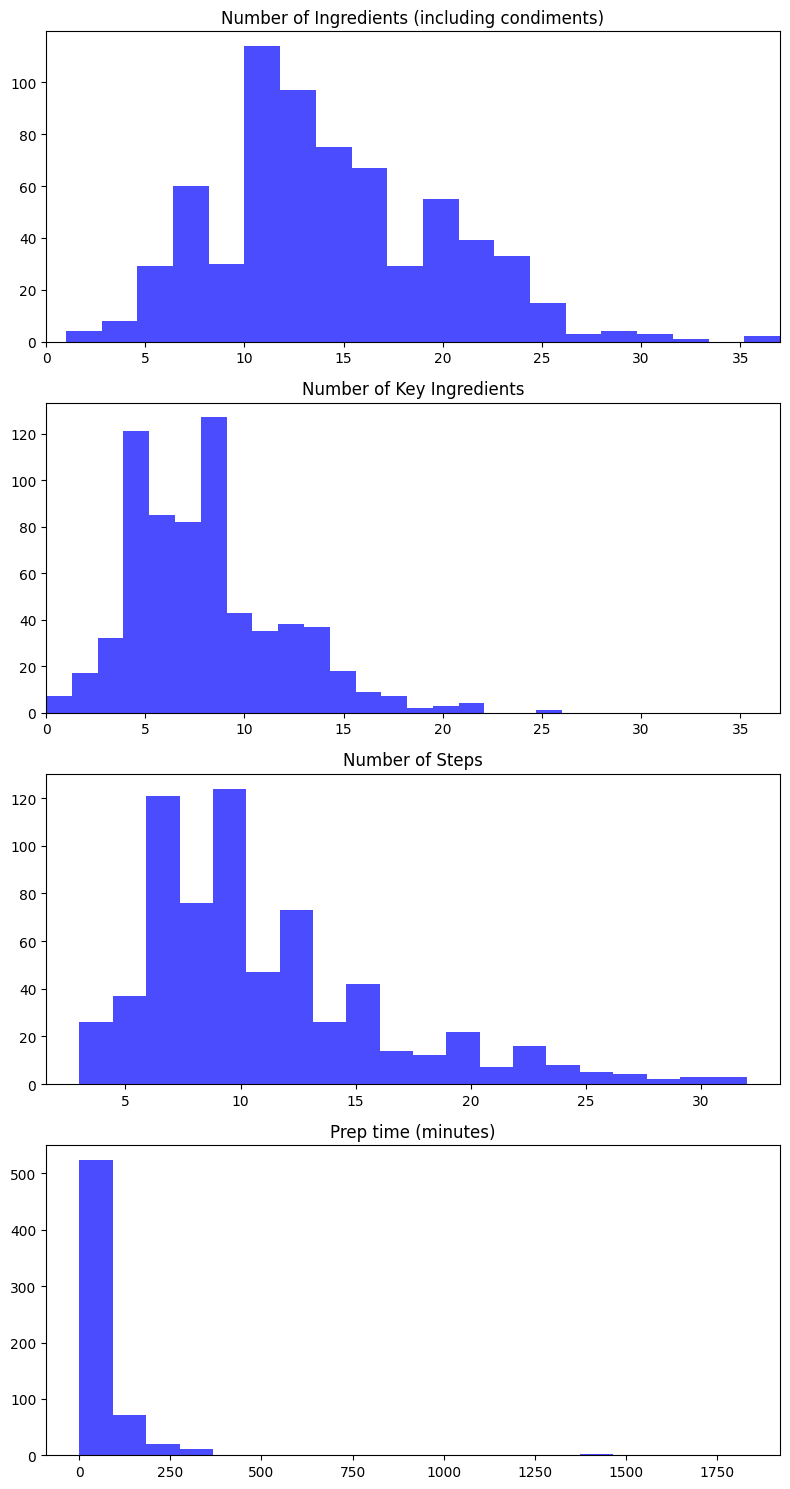

In [123]:

fig, axs = plt.subplots(4, figsize=(8, 15))

# Compute common x-axis limits
common_xlim = (
    min(ingred_ex_df['n_all_ingredients'].min(), ingred_ex_df['n_key_ingredients'].min()),
    max(ingred_ex_df['n_all_ingredients'].max(), ingred_ex_df['n_key_ingredients'].max())
)

# Plot histogram for the number of ingredients, including condiments
axs[0].hist(ingred_ex_df['n_all_ingredients'], bins=20, color='blue', alpha=0.7)
axs[0].set_title('Number of Ingredients (including condiments)')
axs[0].set_xlim(common_xlim)  # Set x-axis limits for the first plot

# Plot histogram for the number of key ingredients
axs[1].hist(ingred_ex_df['n_key_ingredients'], bins=20, color='blue', alpha=0.7)
axs[1].set_title('Number of Key Ingredients')
axs[1].set_xlim(common_xlim)  # Set x-axis limits for the second plot

# Plot histogram for the number of steps
axs[2].hist(ingred_ex_df['n_directions'], bins=20, color='blue', alpha=0.7)
axs[2].set_title('Number of Steps')

# Plot histogram for prep time
axs[3].hist(time_df['prep_time_integer'], bins=20, color='blue', alpha=0.7)
axs[3].set_title('Prep time (minutes)')

plt.tight_layout()
plt.savefig('continuousplots.png', transparent=True)
plt.show()



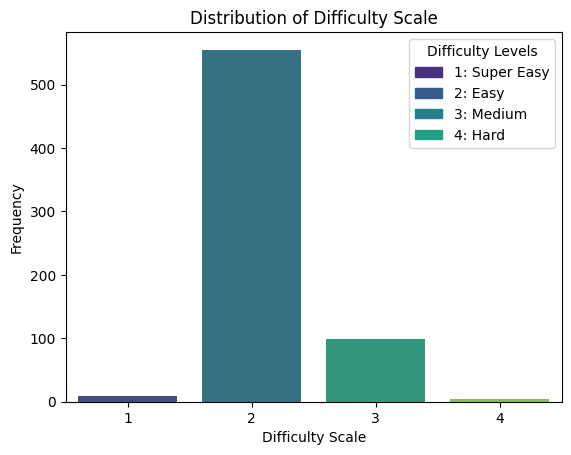

In [122]:
# plot categorical/ordinal features
sns.countplot(x='difficulty_scale', data=meatmen_df, palette='viridis')
plt.title('Distribution of Difficulty Scale')
plt.xlabel('Difficulty Scale')
plt.ylabel('Frequency')

# Create legend patches
legend_labels = [
    mpatches.Patch(color=sns.color_palette('viridis')[0], label='1: Super Easy'),
    mpatches.Patch(color=sns.color_palette('viridis')[1], label='2: Easy'),
    mpatches.Patch(color=sns.color_palette('viridis')[2], label='3: Medium'),
    mpatches.Patch(color=sns.color_palette('viridis')[3], label='4: Hard')
]

# Add the legend
plt.legend(handles=legend_labels, title='Difficulty Levels')

plt.savefig('difficultyplot.png', transparent=True)
plt.show()



In [95]:
# quick description of continuous features
ingred_ex_df[['n_directions', 'n_all_ingredients','n_key_ingredients']].describe()


,n_directions,n_all_ingredients,n_key_ingredients
count,668.000000,668.000000,668.000000
mean,10.989521,14.255988,8.035928
std,5.361158,5.681611,3.809390
min,3.000000,1.000000,0.000000
25%,7.000000,10.000000,5.000000
50%,10.000000,13.000000,7.000000
75%,13.000000,18.000000,10.000000
max,32.000000,37.000000,26.000000


In [98]:
time_df['prep_time_integer'] = pd.to_numeric(time_df['prep_time_integer'])
time_df['prep_time_integer'].describe()

count     631.000000
mean       71.759113
std       123.270675
min         1.000000
25%        25.000000
50%        45.000000
75%        75.000000
max      1830.000000
Name: prep_time_integer, dtype: float64

The median number of steps, total ingredients, key ingredients and prep time for the recipes are: 
- 10 steps 
- 13 total ingredients (including condiments)
- 7 key ingredients 
- 45 min of prep time 

We will use these values as default filter values in the Flask app later.

difficulty_scale     0
n_directions         0
n_all_ingredients    0
n_key_ingredients    0
prep_time_integer    0
dtype: int64


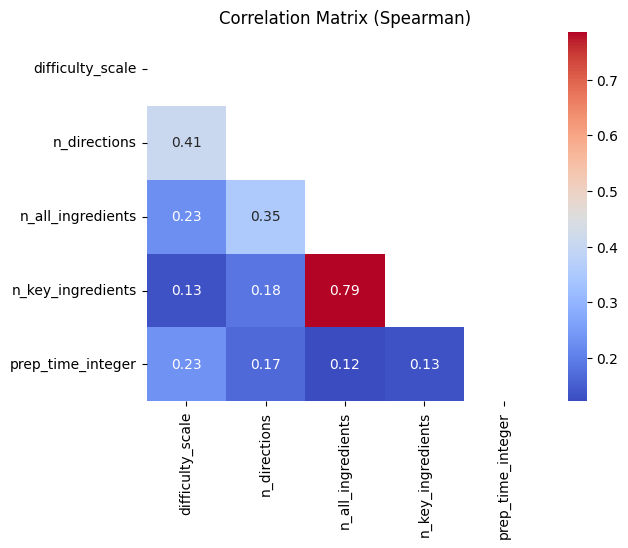

In [121]:
ingred_ex_df['prep_time_integer'] = meatmen_df['prep_time_integer']
ingred_ex_df['difficulty_scale'] = meatmen_df['difficulty_scale']
ingred_ex_df['prep_time_integer'].fillna(0, inplace=True)

# Select the relevant columns
selected_columns = ingred_ex_df[['difficulty_scale', 'n_directions', 'n_all_ingredients', 'n_key_ingredients', 'prep_time_integer']]

print(selected_columns.isna().sum())

# Compute the Spearman's rank correlation matrix
corr_matrix = selected_columns.corr(method='spearman')

# Plot the heatmap of the correlation matrix
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix (Spearman)')
plt.savefig('corr.png', transparent=True)
plt.show()


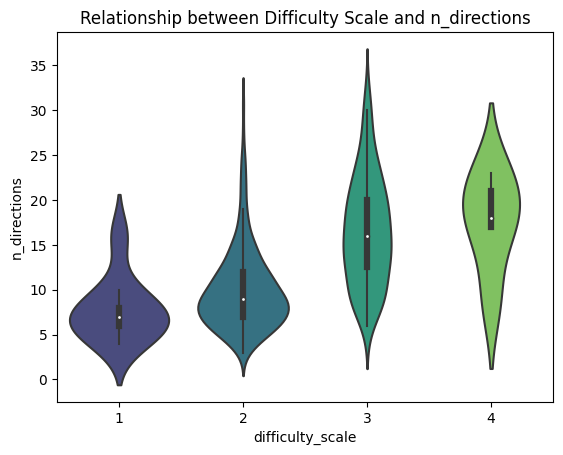

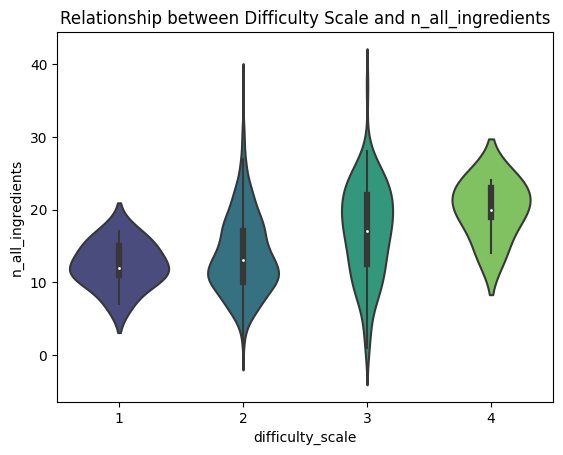

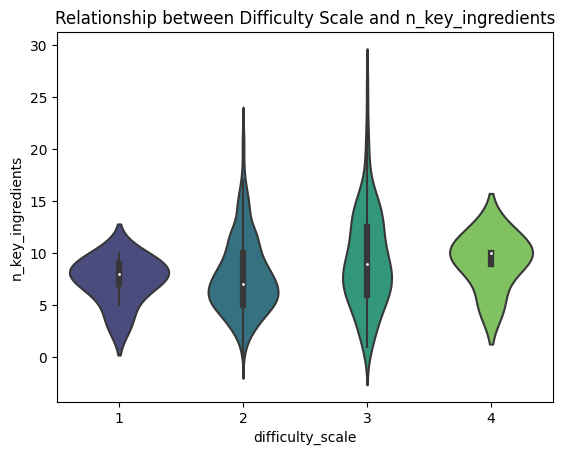

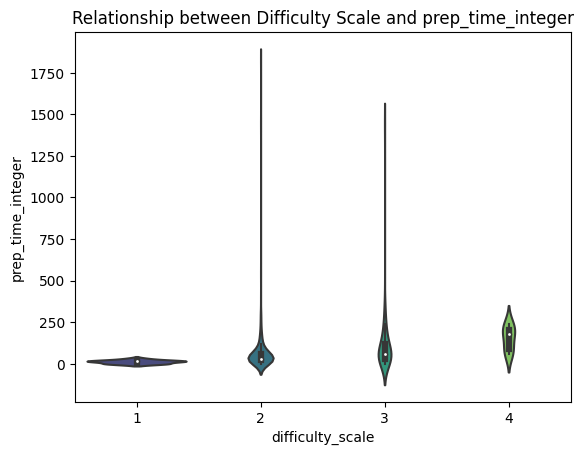

In [124]:
for column in ['n_directions', 'n_all_ingredients', 'n_key_ingredients', 'prep_time_integer']:
    sns.violinplot(x='difficulty_scale', y=column, data=ingred_ex_df, palette='viridis')
    plt.title(f'Relationship between Difficulty Scale and {column}')
    filename = f'violin_{column}.png'  # Unique filename for each plot
    plt.savefig(filename, transparent=True)
    plt.show()


In [24]:
# Count the occurrences of each key ingredient
from collections import Counter
key_ingredient_counts = Counter(all_key_ingredients)

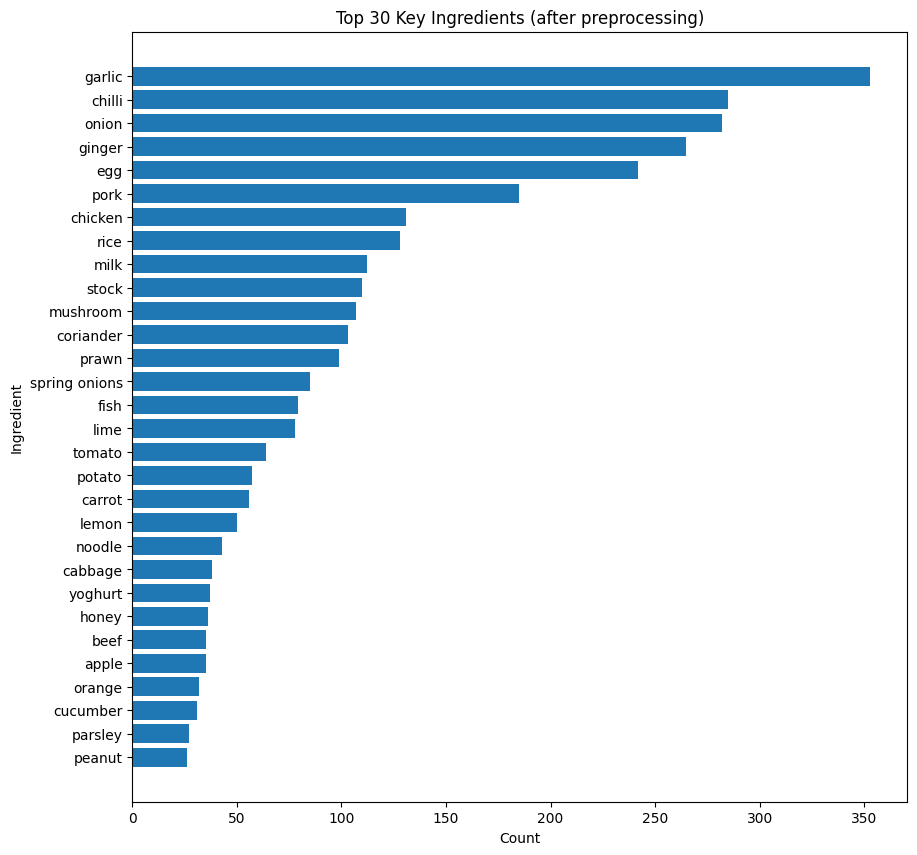

In [118]:
#Plot the occurrences of top 30 key ingredients after preprocessing 

import pandas as pd
import matplotlib.pyplot as plt

# Convert the counter to a DataFrame
key_ingredient_counts_df = pd.DataFrame.from_dict(key_ingredient_counts, orient='index').reset_index()
key_ingredient_counts_df = key_ingredient_counts_df.rename(columns={'index':'key_ingredient', 0:'count'})

# Sort the DataFrame by count
key_ingredient_counts_df = key_ingredient_counts_df.sort_values('count', ascending=False)

# Plot
plt.figure(figsize=(10,10))
plt.barh(key_ingredient_counts_df['key_ingredient'][:30], key_ingredient_counts_df['count'][:30])
plt.xlabel('Count')
plt.ylabel('Ingredient')
plt.title('Top 30 Key Ingredients (after preprocessing)')
plt.gca().invert_yaxis()
plt.savefig('top30processed.png', transparent=True)
plt.show()


In [26]:
print(f"The top 30 common key ingredients are: \n{list(key_ingredient_counts_df['key_ingredient'][:30])}.")

The top 30 common key ingredients are: 
['garlic', 'chilli', 'onion', 'ginger', 'egg', 'pork', 'chicken', 'rice', 'milk', 'stock', 'mushroom', 'coriander', 'prawn', 'spring onions', 'fish', 'lime', 'tomato', 'potato', 'carrot', 'lemon', 'noodle', 'cabbage', 'yoghurt', 'honey', 'beef', 'apple', 'orange', 'cucumber', 'parsley', 'peanut'].


Comparison with ingredients before preprocessing (below). As you can see, the top 30 before preprocessing consisted mainly of condiments which isn't meaningful for our analysis. 

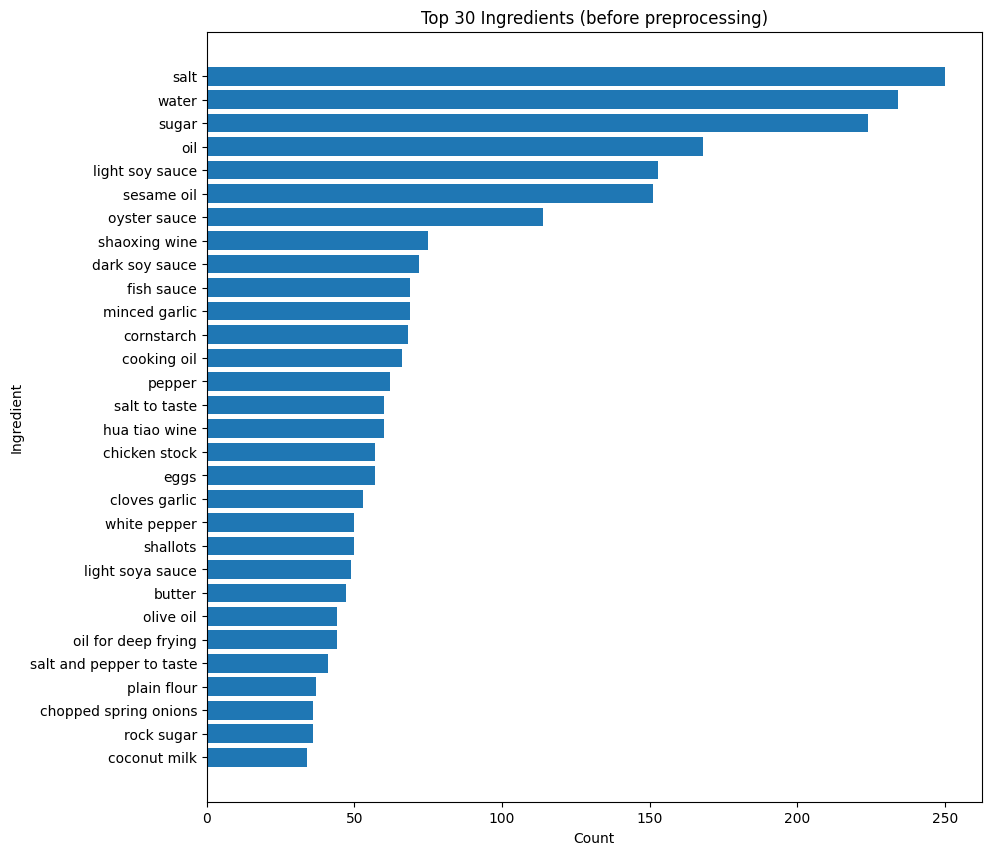

In [119]:
all_ex_ingredients = [ingredient for sublist in ingred_ex_df['ingredients_ex'] for ingredient in sublist]

ex_ingredient_counts = Counter(all_ex_ingredients)

# Convert the counter to a DataFrame
ex_ingredient_counts_df = pd.DataFrame.from_dict(ex_ingredient_counts, orient='index').reset_index()
ex_ingredient_counts_df = ex_ingredient_counts_df.rename(columns={'index':'ingredient', 0:'count'})

# Sort the DataFrame by count
ex_ingredient_counts_df = ex_ingredient_counts_df.sort_values('count', ascending=False)

# Plot
plt.figure(figsize=(10,10))
plt.barh(ex_ingredient_counts_df['ingredient'][:30], ex_ingredient_counts_df['count'][:30])
plt.xlabel('Count')
plt.ylabel('Ingredient')
plt.title('Top 30 Ingredients (before preprocessing)')
plt.gca().invert_yaxis()
plt.savefig('top30beforeprocessed.png', transparent=True)
plt.show()

Based on these top 30 key ingredients, we will create an image dataset (see notebook part 3). 
For the recipe search engine, we will extract the key ingredients via: One-Hot encoding, TF-IDF.

In [28]:
# custom function to treat multi-word ingredients as single terms
def multi2single_terms(ingredients):
    return [ingredient.replace(' ', '_') for ingredient in ingredients]

# Apply preprocessing to key ingredients data
ingred_ex_df['key_ingred_processed'] = ingred_ex_df['key_ingredients'].apply(multi2single_terms)

all_key_ingredients_pro = [ingredient for sublist in ingred_ex_df['key_ingred_processed'] for ingredient in sublist]
key_ingredient_counts_pro = Counter(all_key_ingredients_pro)
key_ingredient_counts_pro_df = pd.DataFrame.from_dict(key_ingredient_counts_pro, orient='index').reset_index()
key_ingredient_counts_pro_df = key_ingredient_counts_pro_df.rename(columns={'index':'key_ingredient', 0:'count'})
key_ingredient_counts_pro_df = key_ingredient_counts_pro_df.sort_values('count', ascending=False)

# e.g. "rice" and "glutinous_rice" will be treated as distinct ingredients

# top_30_ingredients = key_ingredient_counts_pro_df['key_ingredient'][:30].tolist()

# print(top_30_ingredients)

In [29]:

# Create a list of all the ingredients
all_key_ingredients = [' '.join(ingredients) for ingredients in ingred_ex_df['key_ingred_processed']]

# Initialize the TfidfVectorizer 
vectorizer = TfidfVectorizer()

# Fit and transform the vectorizer on our corpus
tfidf_matrix = vectorizer.fit_transform(all_key_ingredients)

print(tfidf_matrix.shape)
print(tfidf_matrix)

# Get the names of the features
features = vectorizer.get_feature_names_out()

print(features)

(668, 1091)
  (0, 180)	0.2037567774671789
  (0, 766)	0.25952556238166385
  (0, 528)	0.3187369963882118
  (0, 953)	0.4813607670555274
  (0, 228)	0.630253837059388
  (0, 637)	0.1854436293197518
  (0, 233)	0.2750566358881699
  (0, 725)	0.2248617474145535
  (1, 543)	0.31452363345942436
  (1, 481)	0.38539278751161415
  (1, 507)	0.38539278751161415
  (1, 961)	0.3624555121195921
  (1, 295)	0.12348014468577946
  (1, 739)	0.3461812562361146
  (1, 931)	0.1629683038069626
  (1, 988)	0.1939368768744618
  (1, 369)	0.09917966401224422
  (1, 876)	0.38539278751161415
  (1, 180)	0.12459486610798737
  (1, 953)	0.29434643139947725
  (1, 637)	0.11339659201959806
  (2, 120)	0.3738753326171644
  (2, 932)	0.3738753326171644
  (2, 1079)	0.24683011540248656
  (2, 309)	0.41622373835539034
  :	:
  (663, 729)	0.34097541225510974
  (663, 988)	0.38887483780499604
  (664, 24)	0.5982525436353678
  (664, 1010)	0.562646575407619
  (664, 423)	0.5373837389105299
  (664, 295)	0.19168057379513
  (665, 959)	0.73833811590704

#### Next, we proceed to build our model via content-based filtering. This approach recommends recipes based on their ingredients. The idea is to recommend recipes that are similar to the ones based on the user's ingredient inputs. 

To implement content-based filtering, we will need to measure the similarity between recipes. We will do this via: 

- **Cosine Similarity:** This measures the cosine of the angle between two vectors. It's a good choice when the dataset is binary (like a one-hot encoded ingredient matrix), because it only considers the dimensions where both vectors are non-zero.

- **Jaccard Similarity:** This measures the size of the intersection of two sets divided by the size of their union. It's a good choice when the dataset is binary and equal weight is given to matches and non-matches.



In [30]:
def get_cosine_rec(ingredients, N):
    
    # Transform the ingredients into a TF-IDF vector
    ingredients_vector = vectorizer.transform([' '.join(ingredients)])

    # Compute the cosine similarity between the TFIDF of input ingredients and
    # TFIDF of the top 30 common key ingredients among the 674 recipes
    similarity_scores = cosine_similarity(ingredients_vector, tfidf_matrix)

    # Get the indices and scores of the top N recipes
    top_recipe_indices = np.argsort(similarity_scores[0])[-N:]
    top_recipe_scores = np.sort(similarity_scores[0])[-N:]

    # Sort the indices and scores in descending order
    top_recipe_indices = top_recipe_indices[::-1]
    top_recipe_scores = top_recipe_scores[::-1]

    # Get the top N recipe recommendations
    top_recipes = ingred_ex_df.iloc[top_recipe_indices]

    # Add the similarity scores to the DataFrame
    top_recipes['similarity_score'] = top_recipe_scores

    return top_recipes


In [31]:
test_ingred = ['garlic', 'onion', 'ginger', 'egg', 'pork', 'rice', 'milk', 'potato', 'carrot']

In [32]:


# test
get_cosine_rec(test_ingred, 5)


,recipe_name,ingredients_ex,n_directions,n_all_ingredients,ingredients_processed,key_ingredients,key_ingred_processed,similarity_score
187,air fryer series sweet sour pork,"[pork shoulder, light soy sauce, rice wine, corn flour, cooking oil, minced garlic, red bell pepper (cut into squares), green bell pepper (cut into squares), yellow bell pepper (cut into squares), onion (cut into squares), pineapple, cornstarch, potato starch, egg, ketchup, plum sauce, rice vinegar, worcestershire sauce, oyster sauce, cornstarch, sugar, water, minced garlic]",9,23,"[pork, soy sauce, rice, flour, oil, garlic, pepper, pepper, pepper, onion, apple, cornstarch, potato, egg, ketchup, plum sauce, vinegar, worcestershire sauce, oyster sauce, cornstarch, sugar, water, garlic]","[pork, rice, garlic, onion, apple, potato, egg, garlic]","[pork, rice, garlic, onion, apple, potato, egg, garlic]",0.642298
209,deep fried kampong chicken,"[boneless chicken thigh (cut into bite sizes), young ginger slices (sliced thinly), potato starch, cornstarch, baking soda, salt, lee kum kee premium oyster sauce, ginger juice, fish sauce, rice wine/shaoxing wine, five spice powder, garlic powder, a dash pepper, a dash sesame oil]",6,14,"[chicken, ginger, potato, cornstarch, baking soda, salt, lee kum kee premium oyster sauce, ginger, fish sauce, rice, five spice powder, garlic, pepper, oil]","[chicken, ginger, potato, ginger, rice, garlic]","[chicken, ginger, potato, ginger, rice, garlic]",0.585254
343,lu rou fan2,"[pork belly, pork skin, minced garlic, ginger (sliced), cinnamon stick, star anise, hua tiao wine, dark soy sauce, light soy sauce, oyster sauce, sesame oil, rock sugar, five spice powder, water, shallot (sliced), oil (for deep frying shallots), eggs ( eggs), water, light soy sauce, mirin, sake, sugar, salt]",17,23,"[pork, pork, garlic, ginger, cinnamon stick, star anise, hua tiao wine, soy sauce, soy sauce, oyster sauce, oil, sugar, five spice powder, water, onion, oil, egg, water, soy sauce, mirin, sake, sugar, salt]","[pork, pork, garlic, ginger, onion, egg]","[pork, pork, garlic, ginger, onion, egg]",0.560468
201,kare pan japanese curry bun,"[bread flour, instant yeast, unsalted butter, fresh milk, marigold dawn sweetened beverage creamer, salt, boneless and skinless chicken thigh, cut into small, carrot (diced), onion (diced), potato (diced), inch grated ginger, cloves grated garlic, small bell pepper (diced), water, box japanese curry sauce mix, eggs (for coating), panko (for final coating)]",20,17,"[flour, instant yeast, butter, milk, marigold dawn sweetened beverage creamer, salt, chicken, carrot, onion, potato, ginger, garlic, pepper, water, box japanese curry sauce mix, egg, panko]","[milk, marigold dawn sweetened beverage creamer, chicken, carrot, onion, potato, ginger, garlic, egg, panko]","[milk, marigold_dawn_sweetened_beverage_creamer, chicken, carrot, onion, potato, ginger, garlic, egg, panko]",0.543128
129,hainanese crispy pork chop,"[pork chop, garlic powder, onion powder, light soy sauce, ginger juice, oyster sauce, cooking cream, white pepper taste, cornstarch, frozen mixed vegetables (frozen peas, carrots, corns), onion (sliced), tomato (diced), potato starch, eggs (beaten), soda cream crackers (crashed), sauce, salted butter, cooking oil, worcestershire sauce, light soy sauce, sugar, ketchup, water, cornstarch solution ( cornstarch water), a squeeze lemon juice]",10,25,"[pork, garlic, onion, soy sauce, ginger, oyster sauce, cooking cream, pepper, cornstarch, carrot, onion, tomato, potato, egg, soda cream crackers, sauce, butter, oil, worcestershire sauce, soy sauce, sugar, ketchup, water, water, lemon]","[pork, garlic, onion, ginger, cooking cream, carrot, onion, tomato, potato, egg, soda cream crackers, lemon]","[pork, garlic, onion, ginger, cooking_cream, carrot, onion, tomato, potato, egg, soda_cream_crackers, lemon]",0.520502


In [33]:
cosine_df = get_cosine_rec(test_ingred, 100)
cosine_df[cosine_df['n_all_ingredients']<=11]

,recipe_name,ingredients_ex,n_directions,n_all_ingredients,ingredients_processed,key_ingredients,key_ingred_processed,similarity_score
487,abc soup,"[small kampung chicken (), white peppercorn, tomatoes, carrots, potatoes, large onion, water, salt]",9,8,"[chicken, pepper, tomato, carrot, potato, onion, water, salt]","[chicken, tomato, carrot, potato, onion]","[chicken, tomato, carrot, potato, onion]",0.519612
340,chinese fried pork chop,"[pork chops ( each, cm thick), light soy sauce, hua tiao wine, sugar, garlic powder, five spice powder, white pepper powder, baking soda, cornstarch, ginger juice, oil for deep frying]",6,11,"[pork, soy sauce, hua tiao wine, sugar, garlic, five spice powder, pepper, baking soda, cornstarch, ginger, oil]","[pork, garlic, ginger]","[pork, garlic, ginger]",0.462689
648,dong po rou,"[pork belly (square), ginger, spring onions, light soy sauce, dark soy sauce, chinese rice wine, rock sugar (adjust to preference), water (or more to cover the pork belly), cornstarch solution, fresh coriander for garnish]",19,10,"[pork, ginger, spring onions, soy sauce, soy sauce, rice, sugar, water, cornstarch]","[pork, ginger, spring onions, rice]","[pork, ginger, spring_onions, rice]",0.437340
222,japanese soft milk buns,"[bread flour, whole wheat flour, instant yeast, butter, nutrisoy oats and quinoa reduced sugar, condensed milk, salt]",6,7,"[flour, flour, instant yeast, butter, sugar, milk, salt]",[milk],[milk],0.369036
163,handmade youtiao,"[baking powder, baking soda, () fresh milk (cold), () plain flour (measure again), salt, vegetable oil]",11,6,"[baking powder, baking soda, milk, flour, salt, oil]",[milk],[milk],0.369036
180,salted egg yolk crab,"[sets mud crabs (approx .), egg (beaten), corn starch/potato starch, butter, minced garlic, salted egg yolks, one handful curry leaves, marigold king kings full cream evaporated milk, sugar, salt to taste]",9,10,"[sets mud crabs, egg, potato, butter, garlic, egg, one handful curry leaves, milk, sugar]","[sets mud crabs, egg, potato, garlic, egg, one handful curry leaves, milk]","[sets__mud_crabs, egg, potato, garlic, egg, one_handful__curry_leaves, milk]",0.364266
126,pork trotter vinegar confinement,"[whole (.) pork trotter (cut into smaller pieces), old ginger (sliced), young ginger (sliced), ( bottle) sweet vinegar, black rice vinegar, sesame oil, stalks scallions, palm sugar, boiled eggs]",4,9,"[pork, ginger, ginger, vinegar, vinegar, oil, scallions, sugar, egg]","[pork, ginger, ginger, scallions, egg]","[pork, ginger, ginger, scallions, egg]",0.358180
682,steamed meat patty with salted egg yolk,"[minced pork, chopped water chestnut, sesame oil, salt, pepper, oyster sauce, salted egg yolk, hua tiao wine, ginger (strips), chili (strips), chopped spring onions]",13,11,"[pork, water, oil, salt, pepper, oyster sauce, egg, hua tiao wine, ginger, chilli, spring onions]","[pork, egg, ginger, chilli, spring onions]","[pork, egg, ginger, chilli, spring_onions]",0.352637
68,vietnamese thit kho,"[. pork belly, hard boiled eggs, cloves garlic (grated), whole shallots (grated), chilli padi (lightly pound), fish sauce, chicken powder, rice syrup, / lemon, coconuts, fish sauce]",6,11,"[pork, egg, garlic, onion, chilli, fish sauce, chicken powder, rice, lemon, coconut, fish sauce]","[pork, egg, garlic, onion, chilli, chicken powder, rice, lemon, coconut]","[pork, egg, garlic, onion, chilli, chicken_powder, rice, lemon, coconut]",0.339381
460,garlic paste pork belly,"[pork belly ( cm thick), slices ginger, spring onion, chinese wine, water, garlic, soya sauce, sugar, water, spring onion (chopped), red chili (finely diced)]",7,11,"[pork, ginger, onion, chinese wine, water, garlic, soy sauce, sugar, water, onion, chilli]","[pork, ginger, onion, chinese wine, garlic, onion, chilli]","[pork, ginger, onion, chinese_wine, garlic, onion, chilli]",0.312258


In [34]:


# Initialize the MultiLabelBinarizer 
mlb = MultiLabelBinarizer()

# Fit and transform the 'key_ingredients' column
one_hot_encoded = mlb.fit_transform(ingred_ex_df['key_ingred_processed'])

# Convert the one-hot encoded matrix into a DataFrame
one_hot_df = pd.DataFrame(one_hot_encoded, columns=mlb.classes_)

def get_cosine_onehot(ingredients, N):
    # Create a binary vector for the input ingredients
    ingredients_vector = np.isin(mlb.classes_, ingredients).astype(int).reshape(1, -1)

    # Compute the cosine similarity between the TFIDF of input ingredients and
    # TFIDF of the top 30 common key ingredients among the 674 recipes
    similarity_scores = cosine_similarity(ingredients_vector, one_hot_encoded)[0]

    # Get the indices and scores of the top N recipes
    top_recipe_indices = np.argsort(similarity_scores)[-N:]
    top_recipe_scores = np.sort(similarity_scores)[-N:]

    # Sort the indices and scores in descending order
    top_recipe_indices = top_recipe_indices[::-1]
    top_recipe_scores = top_recipe_scores[::-1]

    # Get the top N recipe recommendations
    top_recipes = ingred_ex_df.iloc[top_recipe_indices]

    # Add the similarity scores to the DataFrame
    top_recipes['similarity_score'] = top_recipe_scores
      
    return top_recipes


def get_jaccard_rec(ingredients, N):
    # Create a binary vector for the input ingredients
    ingredients_vector = np.isin(mlb.classes_, ingredients).astype(int)

    # Compute the Jaccard similarity between the binary vector of input ingredients and
    # binary vectors of the key ingredients among the 674 recipes
    similarity_scores = [jaccard_score(ingredients_vector, row) for row in one_hot_encoded]


    # Get the indices and scores of the top N recipes
    top_recipe_indices = np.argsort(similarity_scores)[-N:]
    top_recipe_scores = np.sort(similarity_scores)[-N:]

    # Sort the indices and scores in descending order
    top_recipe_indices = top_recipe_indices[::-1]
    top_recipe_scores = top_recipe_scores[::-1]

    # Get the top N recipe recommendations
    top_recipes = ingred_ex_df.iloc[top_recipe_indices]

    # Add the similarity scores to the DataFrame
    top_recipes['similarity_score'] = top_recipe_scores

    return top_recipes



In [35]:
get_cosine_onehot(test_ingred,5)

,recipe_name,ingredients_ex,n_directions,n_all_ingredients,ingredients_processed,key_ingredients,key_ingred_processed,similarity_score
307,hainanese pork chop cny,"[boneless pork chops (about pieces each), soda cream crackers, eggs, plain flour, onion (sliced), frozen mixed veg (corn, peas and carrot), minced garlic, oil, oil for deep-frying, baking soda (optional if marinating overnight), five spice powder, sesame oil, light soy sauce, cornstarch, ginger juice, sauce, dancing chef sweet and sour sauce, light soy sauce, worcestershire sauce, white pepper powder, sugar (adjust to preference), water, cornstarch mix water]",10,23,"[pork, soda cream crackers, egg, flour, onion, carrot, garlic, oil, oil, baking soda, five spice powder, oil, soy sauce, cornstarch, ginger, sauce, dancing chef sweet and sour sauce, soy sauce, worcestershire sauce, pepper, sugar, water, water]","[pork, soda cream crackers, egg, onion, carrot, garlic, ginger]","[pork, soda_cream_crackers, egg, onion, carrot, garlic, ginger]",0.755929
187,air fryer series sweet sour pork,"[pork shoulder, light soy sauce, rice wine, corn flour, cooking oil, minced garlic, red bell pepper (cut into squares), green bell pepper (cut into squares), yellow bell pepper (cut into squares), onion (cut into squares), pineapple, cornstarch, potato starch, egg, ketchup, plum sauce, rice vinegar, worcestershire sauce, oyster sauce, cornstarch, sugar, water, minced garlic]",9,23,"[pork, soy sauce, rice, flour, oil, garlic, pepper, pepper, pepper, onion, apple, cornstarch, potato, egg, ketchup, plum sauce, vinegar, worcestershire sauce, oyster sauce, cornstarch, sugar, water, garlic]","[pork, rice, garlic, onion, apple, potato, egg, garlic]","[pork, rice, garlic, onion, apple, potato, egg, garlic]",0.755929
343,lu rou fan2,"[pork belly, pork skin, minced garlic, ginger (sliced), cinnamon stick, star anise, hua tiao wine, dark soy sauce, light soy sauce, oyster sauce, sesame oil, rock sugar, five spice powder, water, shallot (sliced), oil (for deep frying shallots), eggs ( eggs), water, light soy sauce, mirin, sake, sugar, salt]",17,23,"[pork, pork, garlic, ginger, cinnamon stick, star anise, hua tiao wine, soy sauce, soy sauce, oyster sauce, oil, sugar, five spice powder, water, onion, oil, egg, water, soy sauce, mirin, sake, sugar, salt]","[pork, pork, garlic, ginger, onion, egg]","[pork, pork, garlic, ginger, onion, egg]",0.745356
201,kare pan japanese curry bun,"[bread flour, instant yeast, unsalted butter, fresh milk, marigold dawn sweetened beverage creamer, salt, boneless and skinless chicken thigh, cut into small, carrot (diced), onion (diced), potato (diced), inch grated ginger, cloves grated garlic, small bell pepper (diced), water, box japanese curry sauce mix, eggs (for coating), panko (for final coating)]",20,17,"[flour, instant yeast, butter, milk, marigold dawn sweetened beverage creamer, salt, chicken, carrot, onion, potato, ginger, garlic, pepper, water, box japanese curry sauce mix, egg, panko]","[milk, marigold dawn sweetened beverage creamer, chicken, carrot, onion, potato, ginger, garlic, egg, panko]","[milk, marigold_dawn_sweetened_beverage_creamer, chicken, carrot, onion, potato, ginger, garlic, egg, panko]",0.737865
177,sweet and creamy pork ribs,"[pork ribs (ask butcher to cut into about one thumb size), baking soda, garlic powder, onion powder, fish sauce, oyster sauce, marigold dawn sweetened beverage creamer, cornstarch, egg white, white vinegar, sesame oil, cooking wine, corn flour, potato starch, baking soda, salt to taste, glazing sauce, salted butter, pieces red chilli (sliced), marigold dawn sweetened beverage creamer, marigold king kings full cream evaporated milk, garnish, minced garlic (fried)]",7,23,"[pork, baking soda, garlic, onion, fish sauce, oyster sauce, marigold dawn sweetened beverage creamer, cornstarch, egg, vinegar, oil, cooking wine, flour, potato, baking soda, glazing sauce, butter, chilli, marigold dawn sweetened beverage creamer, milk,

In [36]:
get_jaccard_rec(test_ingred,5)

,recipe_name,ingredients_ex,n_directions,n_all_ingredients,ingredients_processed,key_ingredients,key_ingred_processed,similarity_score
187,air fryer series sweet sour pork,"[pork shoulder, light soy sauce, rice wine, corn flour, cooking oil, minced garlic, red bell pepper (cut into squares), green bell pepper (cut into squares), yellow bell pepper (cut into squares), onion (cut into squares), pineapple, cornstarch, potato starch, egg, ketchup, plum sauce, rice vinegar, worcestershire sauce, oyster sauce, cornstarch, sugar, water, minced garlic]",9,23,"[pork, soy sauce, rice, flour, oil, garlic, pepper, pepper, pepper, onion, apple, cornstarch, potato, egg, ketchup, plum sauce, vinegar, worcestershire sauce, oyster sauce, cornstarch, sugar, water, garlic]","[pork, rice, garlic, onion, apple, potato, egg, garlic]","[pork, rice, garlic, onion, apple, potato, egg, garlic]",0.600000
307,hainanese pork chop cny,"[boneless pork chops (about pieces each), soda cream crackers, eggs, plain flour, onion (sliced), frozen mixed veg (corn, peas and carrot), minced garlic, oil, oil for deep-frying, baking soda (optional if marinating overnight), five spice powder, sesame oil, light soy sauce, cornstarch, ginger juice, sauce, dancing chef sweet and sour sauce, light soy sauce, worcestershire sauce, white pepper powder, sugar (adjust to preference), water, cornstarch mix water]",10,23,"[pork, soda cream crackers, egg, flour, onion, carrot, garlic, oil, oil, baking soda, five spice powder, oil, soy sauce, cornstarch, ginger, sauce, dancing chef sweet and sour sauce, soy sauce, worcestershire sauce, pepper, sugar, water, water]","[pork, soda cream crackers, egg, onion, carrot, garlic, ginger]","[pork, soda_cream_crackers, egg, onion, carrot, garlic, ginger]",0.600000
201,kare pan japanese curry bun,"[bread flour, instant yeast, unsalted butter, fresh milk, marigold dawn sweetened beverage creamer, salt, boneless and skinless chicken thigh, cut into small, carrot (diced), onion (diced), potato (diced), inch grated ginger, cloves grated garlic, small bell pepper (diced), water, box japanese curry sauce mix, eggs (for coating), panko (for final coating)]",20,17,"[flour, instant yeast, butter, milk, marigold dawn sweetened beverage creamer, salt, chicken, carrot, onion, potato, ginger, garlic, pepper, water, box japanese curry sauce mix, egg, panko]","[milk, marigold dawn sweetened beverage creamer, chicken, carrot, onion, potato, ginger, garlic, egg, panko]","[milk, marigold_dawn_sweetened_beverage_creamer, chicken, carrot, onion, potato, ginger, garlic, egg, panko]",0.583333
343,lu rou fan2,"[pork belly, pork skin, minced garlic, ginger (sliced), cinnamon stick, star anise, hua tiao wine, dark soy sauce, light soy sauce, oyster sauce, sesame oil, rock sugar, five spice powder, water, shallot (sliced), oil (for deep frying shallots), eggs ( eggs), water, light soy sauce, mirin, sake, sugar, salt]",17,23,"[pork, pork, garlic, ginger, cinnamon stick, star anise, hua tiao wine, soy sauce, soy sauce, oyster sauce, oil, sugar, five spice powder, water, onion, oil, egg, water, soy sauce, mirin, sake, sugar, salt]","[pork, pork, garlic, ginger, onion, egg]","[pork, pork, garlic, ginger, onion, egg]",0.555556
177,sweet and creamy pork ribs,"[pork ribs (ask butcher to cut into about one thumb size), baking soda, garlic powder, onion powder, fish sauce, oyster sauce, marigold dawn sweetened beverage creamer, cornstarch, egg white, white vinegar, sesame oil, cooking wine, corn flour, potato starch, baking soda, salt to taste, glazing sauce, salted butter, pieces red chilli (sliced), marigold dawn sweetened beverage creamer, marigold king kings full cream evaporated milk, garnish, minced garlic (fried)]",7,23,"[pork, baking soda, garlic, onion, fish sauce, oyster sauce, marigold dawn sweetened beverage creamer, cornstarch, egg, vinegar, oil, cooking wine, flour, potato, baking soda, glazing sauce, butter, chilli, marigold dawn sweetened beverage creamer, milk,

Comparing the recommendations from Jaccard and Cosine similarity approaches, it seems that Jaccard is more intuitive to understand based on its score as equal weight is given to matches and non-matches, which is the project's intent. On the contrary, Cosine similarity scoring can be hard to comprehend since it takes into account the commonness/rarity per ingredient, which does not really account for much business use here, i.e. if a user only has rice and doesn't have noodles at home, it really doesn't make much sense to suggest a recipe that uses noodles just because noodles are similar to rice in terms of it being a source of carb. 

In [37]:
combined_df = pd.merge(meatmen_df, ingred_ex_df, on='recipe_name', how='inner')


def get_mod_jaccard_rec_adj(ingredients, N): #modifying the function to return based on recipe names so that the correct recipe is matched. 
    # Create a binary vector for the input ingredients
    ingredients_vector = np.isin(mlb.classes_, ingredients).astype(int)

    # Compute the Jaccard similarity between the binary vector of input ingredients and
    # binary vectors of the key ingredients among the 674 recipes
    similarity_scores = [jaccard_score(ingredients_vector, row) for row in one_hot_encoded]

    # Get the indices and scores of the top N recipes
    top_recipe_indices = np.argsort(similarity_scores)[-N:]
    top_recipe_scores = np.sort(similarity_scores)[-N:]

    # Sort the indices and scores in descending order
    top_recipe_indices = top_recipe_indices[::-1]
    top_recipe_scores = top_recipe_scores[::-1]

    # Get the top N recipe names
    top_recipe_names = ingred_ex_df.iloc[top_recipe_indices]['recipe_name']

    # Create a DataFrame with the recipe names and similarity scores
    top_recipes = pd.DataFrame({
        'recipe_name': top_recipe_names,
        'similarity_score': top_recipe_scores
    })

    return top_recipes


def show_recommendations(ingredients, N):
    # Get the top N recipe recommendations
    top_recipes = get_mod_jaccard_rec_adj(ingredients, N)

    # Select the desired columns from the combined dataframe
    output = combined_df[combined_df['recipe_name'].isin(top_recipes['recipe_name'])][['recipe_name', 'image', 'ingredients', 'n_all_ingredients', 'difficulty', 'n_directions', 'prep_time', 'url']]

    # Replace the 'image' column with Image objects
    output['image'] = output['image'].apply(lambda url: Image(url=url))

    # Set 'recipe_name' as the index for both DataFrames
    top_recipes.set_index('recipe_name', inplace=True)
    output.set_index('recipe_name', inplace=True)
    
    # Add the similarity scores to the DataFrame
    output['similarity_score'] = top_recipes['similarity_score']
    
    # Sort the DataFrame by 'similarity_score' in descending order
    output.sort_values(by='similarity_score', ascending=False, inplace=True)


    return output



In [38]:
print(combined_df.shape)
print(meatmen_df.shape)
print(ingred_ex_df.shape)

(668, 14)
(668, 8)
(668, 7)


In [39]:
show_recommendations(test_ingred, 5)

,image,ingredients,n_all_ingredients,difficulty,n_directions,prep_time,url,similarity_score
recipe_name,,,,,,,,
air fryer series sweet sour pork,<IPython.core.display.Image object>,"['400g pork shoulder', '2tsp light soy sauce', '2tsp rice wine', '2tsp corn flour', '2tbsp cooking oil', '2tbsp minced garlic', '½red bell pepper (cut into squares)', '½green bell pepper (cut into squares)', '½yellow bell pepper (cut into squares)', '½onion (cut into squares)', '1cup pineapple cubes', '1tbsp cornstarch', '4tbsp potato starch', '1 egg', '4tbsp ketchup', '2tsp plum sauce', '1tsp rice vinegar', '1tsp worcestershire sauce', '2tsp oyster sauce', '2tsp cornstarch', '2tsp sugar', '4tbsp water', '1tbsp minced garlic']",23,easy,9,['30 mins'],https://themeatmen.sg/air-fryer-series-sweet-sour-pork/,0.600000
hainanese pork chop cny,<IPython.core.display.Image object>,"['600g boneless pork chops (about 4 pieces 150g each)', '16soda cream crackers', '2 eggs', '1cup plain flour', '1onion (sliced)', '80g frozen mixed veg (corn, peas and carrot)', '1tbsp minced garlic', '2tbsp oil', 'oil for deep-frying', '½tsp baking soda (optional if marinating overnight)', '1tsp five spice powder', '1tsp sesame oil', '1tbsp light soy sauce', '1tbsp cornstarch', '1tbsp ginger juice', 'Sauce', '1pack Dancing Chef sweet and sour sauce', '1tbsp light soy sauce', '1tbsp Worcestershire sauce', '¼tsp white pepper powder', '½tbsp sugar (adjust to preference)', '1cup water', '1tbsp cornstarch mix with 2 tbsp water']",23,easy,10,['1 hour 20 minutes'],https://themeatmen.sg/hainanese-pork-chop-cny/,0.600000
kare pan japanese curry bun,<IPython.core.display.Image object>,"['200g bread flour', '3g instant yeast', '20g unsalted butter', '160g fresh milk', '100g MARIGOLD Dawn Sweetened Beverage Creamer', '3g salt', '380g boneless and skinless chicken thigh, cut into small cubes', '100g carrot (diced)', '100g onion (diced)', '120g potato (diced)', '1inch knob of grated ginger', '2cloves of grated garlic', '30g small bell pepper (diced)', '150ml water', '1box of Japanese curry sauce mix', '2eggs (for coating)', '1½cup panko (for final coating)']",17,easy,20,['3 hrs'],https://themeatmen.sg/kare-pan-japanese-curry-bun-%e5%92%96%e5%96%b1%e9%9d%a2%e5%8c%85/,0.583333
lu rou fan2,<IPython.core.display.Image object>,"['600g pork belly', '200g pork skin', '30g minced garlic', '10g ginger (sliced)', '1cinnamon stick', '2star anise', '⅓cup Hua Tiao wine', '⅓cup dark soy sauce', '2tbsp light soy sauce', '2tbsp oyster sauce', '1tbsp sesame oil', '20g rock sugar', '1tsp five spice powder', '500ml water', '150g shallot (sliced)', '200g oil (for deep frying shallots)', '8eggs (60g eggs)', '1cup water', '½cup light soy sauce', '½cup mirin', '½cup sake', '½cup sugar', '1tbsp salt']",23,easy,17,['4 hours'],https://themeatmen.sg/lu-rou-fan2/,0.555556
sweet and creamy pork ribs,<IPython.core.display.Image object>,"['800g pork ribs (ask butcher to cut into about one thumb size)', '¼tsp baking soda', '1tbsp garlic powder', '1tbsp onion powder', '2tbsp fish sauce', '2tbsp oyster sauce', '100g MARIGOLD DAWN Sweetened Beverage Creamer', '1tbsp cornstarch', '1egg white', '1tbsp white vinegar', '1tbsp sesame oil', '2tbsp cooking wine', '2tbsp corn flour', '8tbsp potato starch', '1tsp baking soda', '1tsp Salt to taste', 'Glazing sauce', '50g salted butter', '2pieces of red chilli (sliced)', '80g MARIGOLD DAWN Sweetened Beverage Creamer', '50ml MARIGOLD KING OF KINGS Full Cream Evaporated Milk', 'Garnish', '3tbsp minced garlic (fried)']",23,easy,7,['30 minutes'],https://themeatmen.sg/sweet-and-creamy-pork-ribs-%e5%a5%b6%e9%a6%99%e6%8e%92%e9%aa%a8/,0.545455


Based on a set of text inputs, we are able to obtain the closest recipes with a similar set of ingredients. 
We will also use the computer vision model to detect ingredients. These predicted ingredients will be used as input to the recipe recommender.